# Large Scale Data Science (CC3047) - 2024/2025

## Machine Learning Pipeline - Is solving this problem an actual challenge?

Work by Alexandre Sousa (2022206427) and Francisco Carqueija (202205113)

---

The project focuses on building a Machine Learning pipeline that aims to perform large-scale data analysis on patient events in the ICU. The main focuses of this work are:

-> Statistical analysis and visualization of data by patient (SUBJECT_ID)

-> Prediction of length of stay in the ICU with machine learning models.

-> Use appropriate tools to efficiently process large volumes of data (PySpark, MapReduce, BigQuery, etc.).

-> Evaluate and discuss performance issues (execution time, profile).

For this project we need to take into consideration the choices for our preprocessing, the choices for our data preparation, our choices on how to train and validate our models and the quality of the analysis, interpretations and discussion of results

---

# Table of contents

<!-- Hello World -->
1. [Libraries Needed](#Libraries-Needed)
2. [Introduction](#Introduction)
3. [Analysis of part of the MIMIC-III Database](#Analysis-of-part-of-the-MIMIC-III-Database)
    - [ADMISSIONS](#ADMISSIONS)
    - [CHARTEVENTS](#CHARTEVENTS)
    - [D_ITEMS](#D_ITEMS)
    - [DIAGNOSES_ICD](#DIAGNOSES_ICD)
    - [D_ICD_DIAGNOSES](#D_ICD_DIAGNOSES)
    - [ICUSTAYS](#ICUSTAYS)
    - [PATIENTS](#PATIENTS)
    - [PROCEDURES_ICD](#PROCEDURES_ICD)
    - [D_ICD_PROCEDURES](#D_ICD_PROCEDURES)
4. [Obtain the top 5 diseases with more occurencies](#Obtain-the-top-5-diseases-with-more-occurencies)
5. [Merge of the different tables](#Merge-of-the-different-tables)
6. [Exploratory Data Analysis of the Data (raw_features)](#Exploratory-Data-Analysis-of-the-Data-(raw_features))
    - [General Analysis](#General-Analysis)
    - [Specific Analysis](#Specific-Analysis)
        - [Patients Analysis](#Patients-Analysis)
        - [Hospital Admissions Analysis](#Hospital-Admissions-Analysis)


---

# Libraries Needed 

In [1]:
!python -V

Python 3.11.11


In [5]:
import os
from google.cloud import bigquery

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "ml-pipeline-459822-e0958fb6a5e7.json"

client = bigquery.Client()

In [6]:
import bigframes as bf
import bigframes.pandas as bpd

In [7]:
import pandas as pd
import dask.dataframe as dd

In [8]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [9]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, mean as count, when, udf, regexp_replace, coalesce, lit
from pyspark.sql.types import IntegerType
from pyspark.sql import functions as F

In [10]:
import matplotlib.pyplot as plt
import math
from datetime import datetime
import seaborn as sns
import polars as pl

---

# Introduction
[[ go back to the top ]](#Table-of-contents)




### NEED TO CHANGE !!!!!!!!!

The dataset we are analysing is CHARTEVENTS.csv.gz from the MIMIC-III clinical database. 
It contains detailed time-stamped measurements and observations recorded in the ICU, including vital signs (e.g., heart rate, blood pressure, temperature), lab test results, and other patient-specific metrics. Each row corresponds to a single charted event and includes key fields such as SUBJECT_ID (patient identifier), HADM_ID (hospital admission ID), ICUSTAY_ID (ICU stay ID), ITEMID (type of measurement), CHARTTIME (timestamp), and VALUE (the observed or recorded value). The dataset is large and granular, enabling detailed temporal analysis of patient states during ICU stays, which is essential for tasks like predicting length of stay, assessing patient deterioration, and analyzing treatment outcomes.

### -Why we use bigframes.pandas and not other tools

We use bigframes.pandas because it lets us work with massive BigQuery datasets using familiar pandas-like syntax, without downloading the data. All operations run in BigQuery, making it scalable and memory-efficient — ideal for analyzing MIMIC’s large medical tables.

##### Why Not Other Tools
- pandas: Loads all data into memory — crashes with large datasets.
- cuDF: Needs a local GPU, not suited for cloud SQL queries.
- Dask/Polars: Good for local or distributed CSVs, but don’t integrate easily with BigQuery.

---

# Analysis of part of the MIMIC-III Database
[[ go back to the top ]](#Table-of-contents)

Firstly, we get the data from the MIMIC-III database, which is a large dataset containing information about patients in the ICU. The dataset is stored in BigQuery and we use the bigframes.pandas library to access it.

We then proceed to analyze the different tables to get a general understanding of the data we are working with and the relationships between the different tables. 

The tables we chose to analyze are:
- ADMISSIONS
- CHARTEVENTS
- D_ITEMS
- DIAGNOSES_ICD
- D_ICD_DIAGNOSES
- ICUSTAYS
- PATIENTS
- PROCEDURES_ICD
- D_ICD_PROCEDURES  


---

## ADMISSIONS

In [21]:
df_admissions = bpd.read_gbq("SELECT * FROM `ml-pipeline-459822.data.admissions`", use_cache=False)

In [24]:
df_admissions.info()

<class 'bigframes.dataframe.DataFrame'>
Index: 58976 entries, 0 to 58975
Data columns (total 19 columns):
  #  Column                Non-Null Count    Dtype
---  --------------------  ----------------  ------------------------------
  0  ROW_ID                58976 non-null    Int64
  1  SUBJECT_ID            58976 non-null    Int64
  2  HADM_ID               58976 non-null    Int64
  3  ADMITTIME             58976 non-null    timestamp[us, tz=UTC][pyarrow]
  4  DISCHTIME             58976 non-null    timestamp[us, tz=UTC][pyarrow]
  5  DEATHTIME             5854 non-null     timestamp[us, tz=UTC][pyarrow]
  6  ADMISSION_TYPE        58976 non-null    string
  7  ADMISSION_LOCATION    58976 non-null    string
  8  DISCHARGE_LOCATION    58976 non-null    string
  9  INSURANCE             58976 non-null    string
 10  LANGUAGE              33644 non-null    string
 11  RELIGION              58518 non-null    string
 12  MARITAL_STATUS        48848 non-null    string
 13  ETHNICITY        

In [22]:
df_admissions.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,14629,11898,108389,2128-01-13 20:55:00+00:00,2128-01-15 18:20:00+00:00,<NA>,EMERGENCY,EMERGENCY ROOM ADMIT,DISCH-TRAN TO PSYCH HOSP,Private,ENGL,NOT SPECIFIED,SINGLE,WHITE,2128-01-13 18:08:00+00:00,2128-01-13 22:36:00+00:00,OVERDOSE,0,1
1,14339,11705,165730,2165-11-18 13:40:00+00:00,2165-11-27 17:30:00+00:00,<NA>,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Private,<NA>,NOT SPECIFIED,<NA>,OTHER,<NA>,<NA>,NEWBORN,0,1
2,57944,96731,198001,2124-09-11 17:37:00+00:00,2124-09-13 14:38:00+00:00,<NA>,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Medicaid,ENGL,OTHER,SINGLE,BLACK/AFRICAN AMERICAN,2124-09-11 09:32:00+00:00,2124-09-11 19:17:00+00:00,ASTHMA;CHRONIC OBST PULM DISEASE,0,1
3,55611,89600,108570,2106-03-17 11:44:00+00:00,2106-03-20 12:50:00+00:00,2106-03-20 12:50:00+00:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Private,ENGL,NOT SPECIFIED,WIDOWED,WHITE,2106-03-17 10:01:00+00:00,2106-03-17 14:19:00+00:00,ACUTE SUBDURAL HEMATOMA,1,1
4,31247,25553,164133,2146-05-30 20:47:00+00:00,2146-06-22 23:59:00+00:00,<NA>,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,WIDOWED,BLACK/AFRICAN AMERICAN,2146-05-30 19:02:00+00:00,2146-05-30 21:35:00+00:00,COPD EXACERBATION,0,1


---

## CHARTEVENTS


In [32]:
df_chartevents = bpd.read_gbq("ml-pipeline-459822.data.chartevents", use_cache=False)

In [ ]:
df_chartevents.info()

<class 'bigframes.dataframe.DataFrame'>
Index: 330712483 entries, 0 to 330712482
Data columns (total 15 columns):
  #  Column        Dtype
---  ------------  ----------------------
  0  ROW_ID        Int64
  1  SUBJECT_ID    Int64
  2  HADM_ID       Int64
  3  ICUSTAY_ID    Int64
  4  ITEMID        Int64
  5  CHARTTIME     timestamp[us][pyarrow]
  6  STORETIME     timestamp[us][pyarrow]
  7  CGID          Int64
  8  VALUE         string
  9  VALUENUM      Float64
 10  VALUEUOM      string
 11  WARNING       Int64
 12  ERROR         Int64
 13  RESULTSTATUS  string
 14  STOPPED       string
dtypes: Float64(1), Int64(8), string(4), timestamp[us][pyarrow](2)
memory usage: 42331197824 bytes


In [106]:
df_chartevents.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED
0,227480130,1663,162078,295174,8551,2141-04-06 07:50:00,2141-04-06 07:52:00,15004,160,160.0,mmHg,<NA>,<NA>,<NA>,NotStopd
1,35461753,234,134944,233735,776,2106-04-10 12:38:00,2106-04-10 12:42:00,15331,-3,-3.0,<NA>,<NA>,<NA>,Final,NotStopd
2,36434629,423,194013,248770,1484,2169-07-07 02:30:00,2169-07-07 04:25:00,18524,Yes,<NA>,<NA>,<NA>,<NA>,<NA>,NotStopd
3,213123811,19361,128434,276021,392,2177-02-03 04:00:00,2177-02-03 04:19:00,17704,Serous,<NA>,<NA>,<NA>,<NA>,<NA>,NotStopd
4,145067178,21838,143088,200378,3446,2136-08-14 08:00:00,2136-08-14 08:12:00,19371,33-36 weeks gest,<NA>,<NA>,<NA>,<NA>,<NA>,NotStopd


We decided to remove  the following columns from the table because they don’t add useful information for predicting the length of stay in the ICU:

 - STORETIME => This just tells us when the data was manually entered or confirmed, which isn’t important for our goal.
 - CGID – Identifies who entered or validated the data, but that’s not relevant for predicting how long a patient stays.


In [33]:
df_chartevents = df_chartevents.drop(columns=["STORETIME", "CGID"])

---

## D_ITEMS



In [34]:
df_d_items = bpd.read_gbq("SELECT * FROM `ml-pipeline-459822.data.d_items`", use_cache=False)

In [35]:
df_d_items.info()

<class 'bigframes.dataframe.DataFrame'>
Index: 12487 entries, 0 to 12486
Data columns (total 10 columns):
  #  Column        Non-Null Count    Dtype
---  ------------  ----------------  -------
  0  ROW_ID        12487 non-null    Int64
  1  ITEMID        12487 non-null    Int64
  2  LABEL         12484 non-null    string
  3  ABBREVIATION  2992 non-null     string
  4  DBSOURCE      12487 non-null    string
  5  LINKSTO       12487 non-null    string
  6  CATEGORY      6049 non-null     string
  7  UNITNAME      1234 non-null     string
  8  PARAM_TYPE    2992 non-null     string
  9  CONCEPTID     0 non-null        string
dtypes: Int64(2), string(8)
memory usage: 1098856 bytes


In [110]:
df_d_items.head()

,ROW_ID,ITEMID,LABEL,ABBREVIATION,DBSOURCE,LINKSTO,CATEGORY,UNITNAME,PARAM_TYPE,CONCEPTID
0,3325,1996,HIGH MIN. VOL.,<NA>,carevue,chartevents,<NA>,<NA>,<NA>,<NA>
1,4423,6898,TRACHEA DSG,<NA>,carevue,chartevents,<NA>,<NA>,<NA>,<NA>
2,12841,223921,Neuro Symptoms,Neuro Symptoms,metavision,chartevents,Neurological,<NA>,Text,<NA>
3,1655,4813,nutrition labs,<NA>,carevue,chartevents,<NA>,<NA>,<NA>,<NA>
4,556,599,RUL Lung Sounds,<NA>,carevue,chartevents,<NA>,<NA>,<NA>,<NA>


---

## DIAGNOSES_ICD



In [37]:
df_diagnoses_icd = bpd.read_gbq("SELECT * FROM `ml-pipeline-459822.data.diagnoses_icd`", use_cache=False)

In [38]:
df_diagnoses_icd.info()

<class 'bigframes.dataframe.DataFrame'>
Index: 651047 entries, 0 to 651046
Data columns (total 5 columns):
  #  Column      Dtype
---  ----------  -------
  0  ROW_ID      Int64
  1  SUBJECT_ID  Int64
  2  HADM_ID     Int64
  3  SEQ_NUM     Int64
  4  ICD9_CODE   string
dtypes: Int64(4), string(1)
memory usage: 31250256 bytes


In [113]:
df_diagnoses_icd.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,328395,28879,163707,5,4019
1,607827,90609,146682,1,0380
2,577044,83314,108439,2,5070
3,564547,80752,180665,21,42789
4,591003,86662,140257,19,2724


---

## D_ICD_DIAGNOSES


In [39]:
df_d_icd_diagnoses = bpd.read_gbq("SELECT * FROM `ml-pipeline-459822.data.d_icd_diagnoses`", use_cache=False)

In [40]:
df_d_icd_diagnoses.info()

<class 'bigframes.dataframe.DataFrame'>
Index: 14567 entries, 0 to 14566
Data columns (total 4 columns):
  #  Column       Non-Null Count    Dtype
---  -----------  ----------------  -------
  0  ROW_ID       14567 non-null    Int64
  1  ICD9_CODE    14567 non-null    string
  2  SHORT_TITLE  14567 non-null    string
  3  LONG_TITLE   14567 non-null    string
dtypes: Int64(1), string(3)
memory usage: 582680 bytes


In [116]:
df_d_icd_diagnoses.head()

,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,14184,E9839,Undet circ-suffocate NOS,Strangulation or suffocation by unspecified me...
1,11678,E9258,Electric current acc NEC,Accident caused by other electric current
2,8999,7810,Abn involun movement NEC,Abnormal involuntary movements
3,7735,6959,Erythematous cond NOS,Unspecified erythematous condition
4,399,0913,Secondary syph skin,Secondary syphilis of skin or mucous membranes


---

## ICUSTAYS


In [41]:
df_icustays = bpd.read_gbq("SELECT * FROM `ml-pipeline-459822.data.icustays`", use_cache=False)

In [42]:
df_icustays.info()

<class 'bigframes.dataframe.DataFrame'>
Index: 61532 entries, 0 to 61531
Data columns (total 12 columns):
  #  Column          Non-Null Count    Dtype
---  --------------  ----------------  ------------------------------
  0  ROW_ID          61532 non-null    Int64
  1  SUBJECT_ID      61532 non-null    Int64
  2  HADM_ID         61532 non-null    Int64
  3  ICUSTAY_ID      61532 non-null    Int64
  4  DBSOURCE        61532 non-null    string
  5  FIRST_CAREUNIT  61532 non-null    string
  6  LAST_CAREUNIT   61532 non-null    string
  7  FIRST_WARDID    61532 non-null    Int64
  8  LAST_WARDID     61532 non-null    Int64
  9  INTIME          61532 non-null    timestamp[us, tz=UTC][pyarrow]
 10  OUTTIME         61522 non-null    timestamp[us, tz=UTC][pyarrow]
 11  LOS             61522 non-null    Float64
dtypes: Float64(1), Int64(6), string(3), timestamp[us, tz=UTC][pyarrow](2)
memory usage: 6399328 bytes


In [119]:
df_icustays.head()


,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
0,53549,76114,127379,238616,metavision,TSICU,TSICU,14,14,2194-04-28 18:25:13+00:00,2194-04-29 16:01:00+00:00,0.8998
1,53711,76502,197100,298669,metavision,TSICU,TSICU,14,14,2142-11-04 10:29:02+00:00,2142-11-05 13:43:13+00:00,1.1348
2,36549,28843,194297,234364,carevue,TSICU,TSICU,14,14,2156-07-30 20:16:36+00:00,2156-07-31 19:48:40+00:00,0.9806
3,19054,15021,102989,278373,carevue,CSRU,CSRU,14,14,2181-04-05 11:08:06+00:00,2181-04-06 22:46:33+00:00,1.485
4,26492,20892,182895,210457,carevue,NICU,NICU,56,56,2143-05-29 18:41:52+00:00,2143-05-30 13:29:11+00:00,0.7829


---

## PATIENTS

In [43]:
df_patients = bpd.read_gbq("SELECT * FROM `ml-pipeline-459822.data.patients`", use_cache=False)

In [44]:
df_patients.info()

<class 'bigframes.dataframe.DataFrame'>
Index: 46520 entries, 0 to 46519
Data columns (total 8 columns):
  #  Column       Non-Null Count    Dtype
---  -----------  ----------------  ------------------------------
  0  ROW_ID       46520 non-null    Int64
  1  SUBJECT_ID   46520 non-null    Int64
  2  GENDER       46520 non-null    string
  3  DOB          46520 non-null    timestamp[us, tz=UTC][pyarrow]
  4  DOD          15759 non-null    timestamp[us, tz=UTC][pyarrow]
  5  DOD_HOSP     9974 non-null     timestamp[us, tz=UTC][pyarrow]
  6  DOD_SSN      13378 non-null    timestamp[us, tz=UTC][pyarrow]
  7  EXPIRE_FLAG  46520 non-null    Int64
dtypes: Int64(3), string(1), timestamp[us, tz=UTC][pyarrow](4)
memory usage: 3349440 bytes


In [122]:
df_patients.head()

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,33888,51786,F,2090-04-16 00:00:00+00:00,<NA>,<NA>,<NA>,0
1,23653,25061,M,2114-07-11 00:00:00+00:00,2192-12-02 00:00:00+00:00,2192-12-02 00:00:00+00:00,2192-12-02 00:00:00+00:00,1
2,44113,90788,M,2094-04-24 00:00:00+00:00,<NA>,<NA>,<NA>,0
3,3452,3652,F,2042-07-26 00:00:00+00:00,2123-10-14 00:00:00+00:00,2123-10-14 00:00:00+00:00,2123-10-14 00:00:00+00:00,1
4,10760,11381,M,2143-04-22 00:00:00+00:00,<NA>,<NA>,<NA>,0


---

## PROCEDURES_ICD


In [45]:
df_procedures_icd = bpd.read_gbq("SELECT * FROM `ml-pipeline-459822.data.procedures_icd`", use_cache=False)

In [46]:
df_procedures_icd.info()

<class 'bigframes.dataframe.DataFrame'>
Index: 240095 entries, 0 to 240094
Data columns (total 5 columns):
  #  Column      Dtype
---  ----------  -------
  0  ROW_ID      Int64
  1  SUBJECT_ID  Int64
  2  HADM_ID     Int64
  3  SEQ_NUM     Int64
  4  ICD9_CODE   Int64
dtypes: Int64(5)
memory usage: 11524560 bytes


In [125]:
df_procedures_icd.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,66403,25809,117092,5,9604
1,13101,2237,142708,2,3606
2,23025,1563,183430,4,9672
3,198865,53463,183511,7,9711
4,201551,99544,145236,15,7966


---

## D_ICD_PROCEDURES

In [47]:
df_d_icd_procedures = bpd.read_gbq("SELECT * FROM `ml-pipeline-459822.data.d_icd_procedures`", use_cache=False)

In [48]:
df_d_icd_procedures.info()

<class 'bigframes.dataframe.DataFrame'>
Index: 3882 entries, 0 to 3881
Data columns (total 4 columns):
  #  Column       Non-Null Count    Dtype
---  -----------  ----------------  -------
  0  ROW_ID       3882 non-null     Int64
  1  ICD9_CODE    3882 non-null     Int64
  2  SHORT_TITLE  3882 non-null     string
  3  LONG_TITLE   3882 non-null     string
dtypes: Int64(2), string(2)
memory usage: 155280 bytes


In [128]:
df_d_icd_procedures.head()

,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,1100,2169,Turbinectomy NEC,Other turbinectomy
1,796,3887,Occlude abd vein NEC,"Other surgical occlusion of vessels, abdominal..."
2,2056,8423,Forearm/wrist/hand reatt,"Forearm, wrist, or hand reattachment"
3,723,3857,Abd varicos v liga-strip,"Ligation and stripping of varicose veins, abdo..."
4,3178,9461,Alcohol rehabilitation,Alcohol rehabilitation


---

# Obtain the top 5 diseases with more occurencies

[[ go back to the top ]](#Table-of-contents)

In this section, we will obtain the top 5 diseases with more occurrences in the MIMIC-III database. We will use the DIAGNOSES_ICD and D_ICD_DIAGNOSES tables to get the information we need.

In [130]:
# Step 1: Get top 3 ICD9 codes by frequency
top_5_codes = df_diagnoses_icd['ICD9_CODE'].value_counts().head(5).index

print("Top 5 most common disease codes:")
# Step 2: Loop through the top codes and retrieve their SHORT_TITLE
for code in top_5_codes:
    # Filter for the corresponding row in d_icd_diagnoses
    filtered_row = df_d_icd_diagnoses[df_d_icd_diagnoses['ICD9_CODE'] == code]
    
    if not filtered_row.empty:
        short_title = filtered_row['SHORT_TITLE'].values[0]
        count = df_diagnoses_icd['ICD9_CODE'].value_counts()[code]
        print(f"{short_title} ({code}) — {count} occurrences")
    else:
        print(f"ICD9 code {code} not found in the descriptions table.")

Top 5 most common disease codes:
Hypertension NOS (4019) — 20703 occurrences
CHF NOS (4280) — 13111 occurrences
Atrial fibrillation (42731) — 12891 occurrences
Crnry athrscl natve vssl (41401) — 12429 occurrences
Acute kidney failure NOS (5849) — 9119 occurrences


---

# Merge of the different tables

[[ go back to the top ]](#Table-of-contents)

In this part, we get the data we’re going to use. We start by selecting useful information from several tables, like patient details, ICU stay info, and vital sign measurements.

We then save that full dataset into a BigQuery table called all_features.

After that, we add diagnosis information by joining with another table that has ICD9 disease codes. We only keep rows related to the 5 most common diagnoses in our data. This cleaned and filtered version is saved in a new table called raw_features, which we’ll use for the machine learning part.

In [9]:
query = """
SELECT DISTINCT
  chartevents.SUBJECT_ID,
  chartevents.HADM_ID,
  chartevents.ICUSTAY_ID,
  chartevents.CHARTTIME,
  chartevents.VALUEUOM,
  patients.DOB,
  admissions.ADMITTIME,
  admissions.DISCHTIME,
  admissions.DEATHTIME,
  admissions.HOSPITAL_EXPIRE_FLAG,
  admissions.ADMISSION_TYPE,
  patients.GENDER,
  admissions.ETHNICITY,
  admissions.RELIGION,
  admissions.LANGUAGE,
  admissions.MARITAL_STATUS,
  admissions.INSURANCE,
  chartevents.ITEMID,
  d_items.LABEL,
  d_items.CATEGORY,
  chartevents.VALUE,
  chartevents.VALUENUM,
  chartevents.WARNING,
  chartevents.ERROR,
  icustays.INTIME,
  icustays.LOS
FROM
  `ml-pipeline-459822.data.chartevents` AS chartevents
LEFT JOIN
  `ml-pipeline-459822.data.patients` AS patients
  ON chartevents.SUBJECT_ID = patients.SUBJECT_ID
LEFT JOIN
  `ml-pipeline-459822.data.d_items` AS d_items
  ON chartevents.ITEMID = d_items.ITEMID
LEFT JOIN
  `ml-pipeline-459822.data.admissions` AS admissions
  ON chartevents.HADM_ID = admissions.HADM_ID
LEFT JOIN
  `ml-pipeline-459822.data.icustays` AS icustays
  ON chartevents.ICUSTAY_ID = icustays.ICUSTAY_ID
"""
# Executing the SQL query and storing the results in the 'all_features' dataframe
all_features = bpd.read_gbq(query, use_cache=False)

# Displaying the resulting dataframe
all_features.head()

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,CHARTTIME,VALUEUOM,DOB,ADMITTIME,DISCHTIME,DEATHTIME,HOSPITAL_EXPIRE_FLAG,...,INSURANCE,ITEMID,LABEL,CATEGORY,VALUE,VALUENUM,WARNING,ERROR,INTIME,LOS
0,69630,173873,270282,2148-08-31 04:29:00,<NA>,1848-08-31 00:00:00+00:00,2148-08-31 04:08:00+00:00,2148-09-02 02:30:00+00:00,2148-09-02 02:30:00+00:00,1,...,Medicare,224072,Education Learner,Restraint/Support Systems,Significant Other/Family,<NA>,0,0,2148-08-31 04:10:27+00:00,1.9756
1,21981,142257,218183,2102-03-14 11:00:00,<NA>,1802-03-03 00:00:00+00:00,2102-03-03 07:05:00+00:00,2102-03-14 12:00:00+00:00,2102-03-14 12:00:00+00:00,1,...,Medicare,617,Respiratory Pattern,<NA>,Regular,<NA>,<NA>,<NA>,2102-03-03 07:06:34+00:00,11.7225
2,13415,189790,230701,2108-09-21 07:00:00,<NA>,2108-08-16 00:00:00+00:00,2108-08-16 18:03:00+00:00,2108-10-08 12:00:00+00:00,<NA>,0,...,Private,3429,Feeding Tube Size,<NA>,5,5.0,<NA>,<NA>,2108-08-16 18:24:23+00:00,52.8522
3,15057,102540,227356,2123-03-04 20:00:00,<NA>,2064-03-13 00:00:00+00:00,2123-02-22 07:02:00+00:00,2123-03-13 13:05:00+00:00,<NA>,0,...,Private,663,Support Systems,<NA>,Spouse,<NA>,<NA>,<NA>,2123-03-03 08:05:48+00:00,6.1916
4,83749,122354,206253,2102-02-21 20:18:00,<NA>,2033-04-08 00:00:00+00:00,2102-02-16 18:05:00+00:00,2102-04-14 13:08:00+00:00,2102-04-14 13:08:00+00:00,1,...,Medicare,224055,Braden Moisture,Skin - Assessment,Occasionally Moist,3.0,0,0,2102-02-16 18:05:21+00:00,50.0966


In [10]:
# Writing the 'all_features' dataframe to the 'cdl-pratica.Data.all_features' table in Google BigQuery, replacing it if it already exists
all_features.to_gbq('ml-pipeline-459822.data.all_features', if_exists='replace')

'ml-pipeline-459822.data.all_features'

In [11]:
# SQL query to select all features from the 'all_features' table and additional diagnosis-related columns from the 'df_diagnoses' table,
# joining them on the 'SUBJECT_ID' column and filtering rows where the 'ICD9_CODE' column equals '4019'
query2 = """
SELECT DISTINCT
  af.*,
  d.ICD9_CODE,
  d.SEQ_NUM
FROM
  `ml-pipeline-459822.data.all_features` AS af
LEFT JOIN
  `ml-pipeline-459822.data.diagnoses_icd` AS d
ON
  af.SUBJECT_ID = d.SUBJECT_ID AND af.HADM_ID = d.HADM_ID
WHERE
  d.ICD9_CODE IN ('4019', '42731', '4280', '41401', '5849')
"""

# Executing the SQL query and storing the results in the 'raw_features' dataframe
raw_features = bpd.read_gbq(query2, use_cache=False)



# Displaying the resulting dataframe
raw_features.head()

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,CHARTTIME,VALUEUOM,DOB,ADMITTIME,DISCHTIME,DEATHTIME,HOSPITAL_EXPIRE_FLAG,...,LABEL,CATEGORY,VALUE,VALUENUM,WARNING,ERROR,INTIME,LOS,ICD9_CODE,SEQ_NUM
0,22076,154613,205674,2160-11-22 01:00:00,%,2079-11-28 00:00:00+00:00,2160-11-15 16:25:00+00:00,2160-11-28 16:15:00+00:00,<NA>,0,...,SpO2 Alarm [High],<NA>,100,100.0,<NA>,<NA>,2160-11-21 11:05:48+00:00,2.3177,4019,10
1,11765,196798,244301,2167-05-15 03:00:00,<NA>,2114-01-22 00:00:00+00:00,2167-04-28 22:55:00+00:00,2167-07-02 11:45:00+00:00,<NA>,0,...,Ectopy Type,<NA>,None,<NA>,<NA>,<NA>,2167-04-28 22:56:33+00:00,24.7562,41401,14
2,46156,127108,258962,2134-08-31 21:16:00,insp/min,2053-06-04 00:00:00+00:00,2134-08-16 16:37:00+00:00,2134-09-07 16:47:00+00:00,<NA>,0,...,Respiratory Rate (spontaneous),Respiratory,0,0.0,0,0,2134-08-16 16:38:08+00:00,19.0972,4280,18
3,80454,147903,247883,2175-06-07 12:00:00,<NA>,2105-06-04 00:00:00+00:00,2175-06-06 11:30:00+00:00,2175-06-16 14:00:00+00:00,<NA>,0,...,Dorsal PedPulse L,Cardiovascular (Pulses),Easily Palpable,<NA>,0,0,2175-06-06 10:04:35+00:00,1.2221,4019,8
4,6024,104644,254201,2125-01-02 12:00:00,kg,2057-07-06 00:00:00+00:00,2124-12-31 20:35:00+00:00,2125-01-03 16:30:00+00:00,<NA>,0,...,Previous WeightF,<NA>,66.199996948242188,66.199997,<NA>,<NA>,2124-12-31 20:36:08+00:00,1.7858,4019,1


In [12]:
# Writing the 'raw_features' dataframe to the 'cdl-pratica.Data.raw_features' table in Google BigQuery, replacing it if it already exists
raw_features.to_gbq('ml-pipeline-459822.data.raw_features', if_exists='replace')     

'ml-pipeline-459822.data.raw_features'

------

# Exploratory Data Analysis of the Data (raw_features)
[[ go back to the top ]](#Table-of-contents)

For the exploratory data analysis, we will use the raw_features table that we created in the previous section, so from here on out we will be analysing always the information of the top 5 diseases with more occurrences in the MIMIC-III database.

We will divide the analysis into two parts:
1. **General Analysis**: We will analyze the data in general, without focusing on any specific topic
2. **Specific Analysis**: We will analyze the data focusing on specific information about the patients and the hospital admissions

This way we can get a general understanding of the data and then focus on specific topics that are more relevant to our goal of predicting the length of stay in the ICU. 

In [35]:
# Reading data from the 'cdl-pratica.Data.raw_features' table in Google BigQuery into a pandas DataFrame
raw_features = bpd.read_gbq("ml-pipeline-459822.data.raw_features")

In [8]:
raw_features.head()

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,CHARTTIME,DOB,ADMITTIME,DISCHTIME,DEATHTIME,HOSPITAL_EXPIRE_FLAG,ADMISSION_TYPE,...,CATEGORY,VALUE,VALUENUM,WARNING,ERROR,INTIME,OUTTIME,LOS,ICD9_CODE,SEQ_NUM
0,32670,187678,255943,2164-05-23 11:00:00,2083-03-02 00:00:00+00:00,2164-05-17 20:34:00+00:00,2164-05-24 10:50:00+00:00,<NA>,0,EMERGENCY,...,<NA>,On Guideline,<NA>,<NA>,<NA>,2164-05-18 15:06:43+00:00,2164-05-24 10:59:53+00:00,5.8286,5849,3
1,4644,148758,223853,2133-03-26 22:00:00,2062-06-29 00:00:00+00:00,2133-03-24 01:37:00+00:00,2133-03-31 12:15:00+00:00,<NA>,0,EMERGENCY,...,<NA>,1,1.0,<NA>,<NA>,2133-03-24 01:37:55+00:00,2133-03-31 12:51:50+00:00,7.468,42731,6
2,12379,124566,238302,2186-08-03 21:00:00,2121-11-28 00:00:00+00:00,2186-08-03 07:15:00+00:00,2186-08-07 17:25:00+00:00,<NA>,0,ELECTIVE,...,<NA>,None,<NA>,<NA>,<NA>,2186-08-03 09:55:42+00:00,2186-08-04 18:03:21+00:00,1.3386,4019,5
3,84378,124808,271862,2179-11-25 02:00:00,2119-09-21 00:00:00+00:00,2179-11-17 02:14:00+00:00,2179-12-07 17:00:00+00:00,<NA>,0,EMERGENCY,...,Routine Vital Signs,None,<NA>,0,0,2179-11-17 02:15:24+00:00,2179-12-06 15:07:18+00:00,19.536,42731,15
4,19568,102532,230624,2124-11-06 06:00:00,2066-11-06 00:00:00+00:00,2124-11-04 16:42:00+00:00,2124-11-07 01:12:00+00:00,2124-11-07 01:12:00+00:00,1,EMERGENCY,...,<NA>,8,8.0,<NA>,<NA>,2124-11-05 14:47:55+00:00,2124-11-07 04:42:41+00:00,1.5797,5849,2


## **General Analysis**
[[ go back to the top ]](#Table-of-contents)

In this section, we will analyze the data in general, without focusing on any specific topic.
The analysis that take part in this section are as follows:
- **Number of rows and columns**: We will check how many rows and columns we have in the dataset.
- **Data types**: We will check the data types of the columns in the dataset.
- **Missing values**: We will check if there are any missing values in the dataset.
- **Distrbution of the length of stay**: We will check the distribution of the length of stay in the ICU.
- **Distribution of Hospital Duration**: We will check the distribution of the length of stay in the ICU by hospital.
- **Most common clinical measurements**: We will check the most common clinical measurements in the dataset.
- **Example of time curve of a patient**: We will check the time curve of a patient to see how the clinical measurements change over time.

### Number of rows and columns

In [18]:
raw_features.shape

(406235959, 28)

### Information about the number of entries, columns, and data types

In [16]:
raw_features.info()

<class 'bigframes.dataframe.DataFrame'>
Index: 406235959 entries, 0 to 406235958
Data columns (total 28 columns):
  #  Column                Dtype
---  --------------------  ------------------------------
  0  SUBJECT_ID            Int64
  1  HADM_ID               Int64
  2  ICUSTAY_ID            Int64
  3  CHARTTIME             timestamp[us][pyarrow]
  4  VALUEUOM              string
  5  DOB                   timestamp[us, tz=UTC][pyarrow]
  6  ADMITTIME             timestamp[us, tz=UTC][pyarrow]
  7  DISCHTIME             timestamp[us, tz=UTC][pyarrow]
  8  DEATHTIME             timestamp[us, tz=UTC][pyarrow]
  9  HOSPITAL_EXPIRE_FLAG  Int64
 10  ADMISSION_TYPE        string
 11  GENDER                string
 12  ETHNICITY             string
 13  RELIGION              string
 14  LANGUAGE              string
 15  MARITAL_STATUS        string
 16  INSURANCE             string
 17  ITEMID                Int64
 18  LABEL                 string
 19  CATEGORY              string
 20  VAL

### Checking for missing values

In [15]:
raw_features.isnull().sum()

SUBJECT_ID                      0
HADM_ID                         0
ICUSTAY_ID                 261508
CHARTTIME                       0
VALUEUOM                263805454
DOB                             0
ADMITTIME                       0
DISCHTIME                       0
DEATHTIME               322990383
HOSPITAL_EXPIRE_FLAG            0
ADMISSION_TYPE                  0
GENDER                          0
ETHNICITY                       0
RELIGION                  2693777
LANGUAGE                147914602
MARITAL_STATUS           18661087
INSURANCE                       0
ITEMID                          0
LABEL                           0
CATEGORY                231786777
VALUE                     2526502
VALUENUM                223935703
WARNING                 244699816
ERROR                   244699816
INTIME                     261508
dtype: Int64

### Columns with Missing Values (Sorted by %)


/var/folders/2s/klc5jhq94c906gjssf2jnj7c0000gn/T/ipykernel_15639/1851877683.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=missing_df, x="Percent", y="Column", palette="crest")


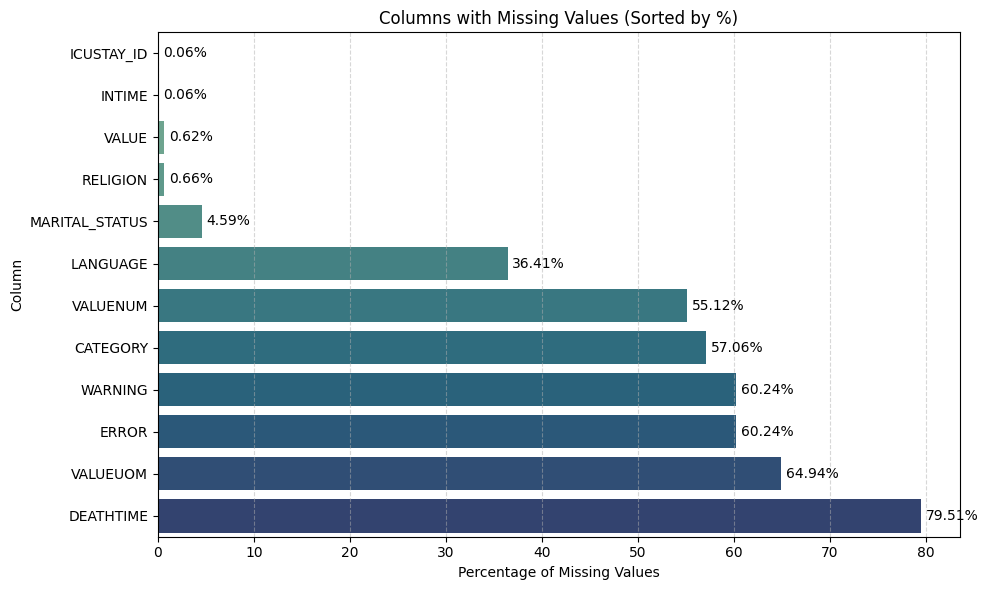

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Updated total number of rows
total_rows = 406_235_959

# Dictionary of columns and their missing counts
missing_counts = {
    "ICUSTAY_ID": 261_508,
    "VALUEUOM": 263_805_454,
    "DEATHTIME": 322_990_383,
    "RELIGION": 2_693_777,
    "LANGUAGE": 147_914_602,
    "MARITAL_STATUS": 18_661_087,
    "CATEGORY": 231_786_777,
    "VALUE": 2_526_502,
    "VALUENUM": 223_935_703,
    "WARNING": 244_699_816,
    "ERROR": 244_699_816,
    "INTIME": 261_508,
}

# Create DataFrame
missing_df = pd.DataFrame(
    [(col, count, (count / total_rows) * 100) for col, count in missing_counts.items()],
    columns=["Column", "Missing", "Percent"]
)

# Sort and reset index so we can use the row index for positioning
missing_df.sort_values("Percent", inplace=True)
missing_df.reset_index(drop=True, inplace=True)

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=missing_df, x="Percent", y="Column", palette="crest")

# Add percentage labels to the right of each bar
for i, row in missing_df.iterrows():
    ax.text(row["Percent"] + 0.5, i, f"{row['Percent']:.2f}%", va="center")

# Aesthetics
plt.title("Columns with Missing Values (Sorted by %)")
plt.xlabel("Percentage of Missing Values")
plt.ylabel("Column")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Distribution of ICU Length of Stay (LOS)

/var/folders/2s/klc5jhq94c906gjssf2jnj7c0000gn/T/ipykernel_15639/3027288067.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=los_df, x='los_group', y='total_pacientes', palette='Blues_d')


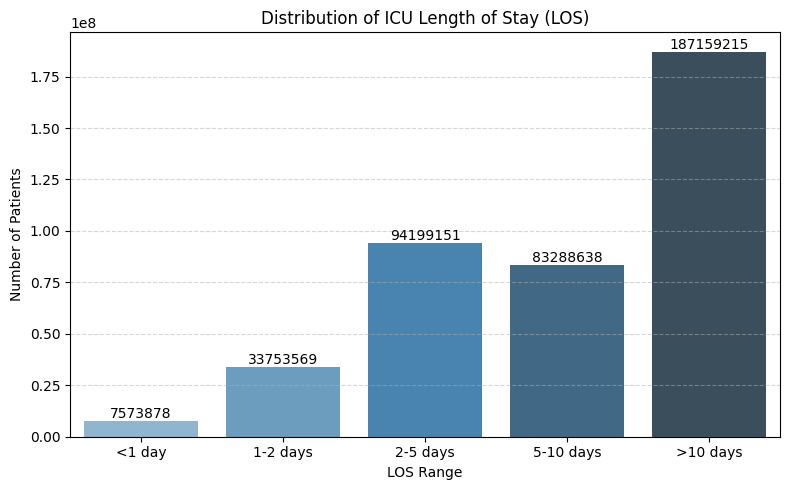

In [ ]:
# # Query to calculate the distribution of ICU Length of Stay (LOS) in days
# query_los = """
# SELECT
#   CASE
#     WHEN LOS < 1 THEN '<1 day'
#     WHEN LOS BETWEEN 1 AND 2 THEN '1-2 days'
#     WHEN LOS BETWEEN 2 AND 5 THEN '2-5 days'
#     WHEN LOS BETWEEN 5 AND 10 THEN '5-10 days'
#     ELSE '>10 days'
#   END AS los_group,
#   COUNT(*) AS total_pacientes
# FROM
#   `ml-pipeline-459822.data.raw_features`
# WHERE
#   LOS IS NOT NULL
# GROUP BY
#   los_group
# """

# los_df = bpd.read_gbq(query_los).to_pandas()

# Define order and sort DataFrame
order = ['<1 day', '1-2 days', '2-5 days', '5-10 days', '>10 days']
los_df['los_group'] = pd.Categorical(los_df['los_group'], categories=order, ordered=True)
los_df = los_df.sort_values('los_group')

# Plot
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=los_df, x='los_group', y='total_pacientes', palette='Blues_d')

# Add value labels above bars
for bar in ax.patches:
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    ax.text(x, y + 100, f'{int(y)}', ha='center', va='bottom')

# Aesthetics
plt.title("Distribution of ICU Length of Stay (LOS)")
plt.xlabel("LOS Range")
plt.ylabel("Number of Patients")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Distribution of Hospital Duration

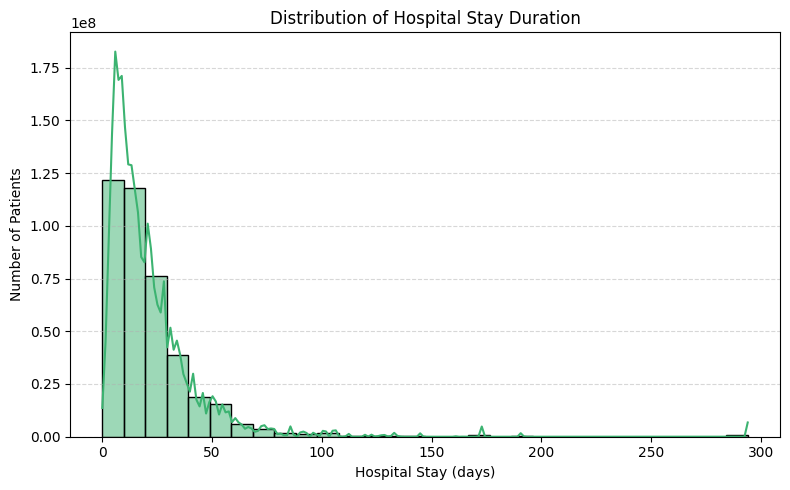

In [14]:
query = """
SELECT
  DATE_DIFF(DISCHTIME, ADMITTIME, DAY) AS hospital_stay_days
FROM
  `ml-pipeline-459822.data.raw_features`
WHERE
  DISCHTIME IS NOT NULL AND ADMITTIME IS NOT NULL
"""

hospital_stay = bpd.read_gbq(query).to_pandas()

plt.figure(figsize=(8, 5))
sns.histplot(hospital_stay['hospital_stay_days'], bins=30, kde=True, color='mediumseagreen')
plt.title("Distribution of Hospital Stay Duration")
plt.xlabel("Hospital Stay (days)")
plt.ylabel("Number of Patients")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### Most commonly recorded clinical measurements in the ICU

/var/folders/2s/klc5jhq94c906gjssf2jnj7c0000gn/T/ipykernel_15639/131455491.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_labels, y='LABEL', x='total_ocorrencias', palette='Blues_d')


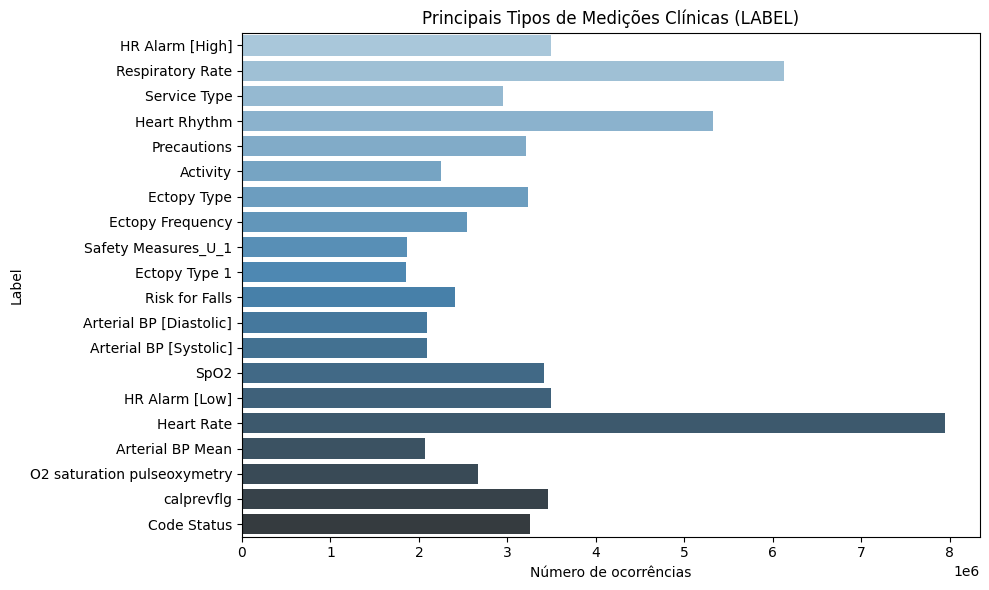

In [ ]:
# query = """
# SELECT
#   di.LABEL,
#   COUNT(*) AS total_ocorrencias
# FROM
#   `ml-pipeline-459822.data.chartevents` AS ce
# JOIN
#   `ml-pipeline-459822.data.d_items` AS di
# ON
#   ce.ITEMID = di.ITEMID
# GROUP BY
#   di.LABEL
# ORDER BY
#   total_ocorrencias DESC
# LIMIT 20
# """

# top_labels = bpd.read_gbq(query).to_pandas()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=top_labels, y='LABEL', x='total_ocorrencias', palette='Blues_d')
plt.title("Principais Tipos de Medições Clínicas (LABEL)")
plt.xlabel("Número de ocorrências")
plt.ylabel("Label")
plt.tight_layout()
plt.show()

### Example of a time curve of the "Heart Rate", "SpO2", "Respiratory Rate" and "Temperature" metrics for a random patient


 Curvas temporais – Paciente 10006 – Estadia 206504


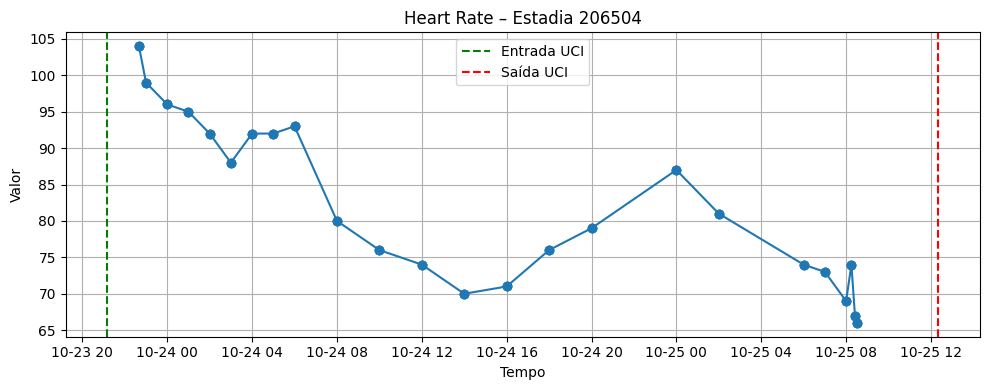

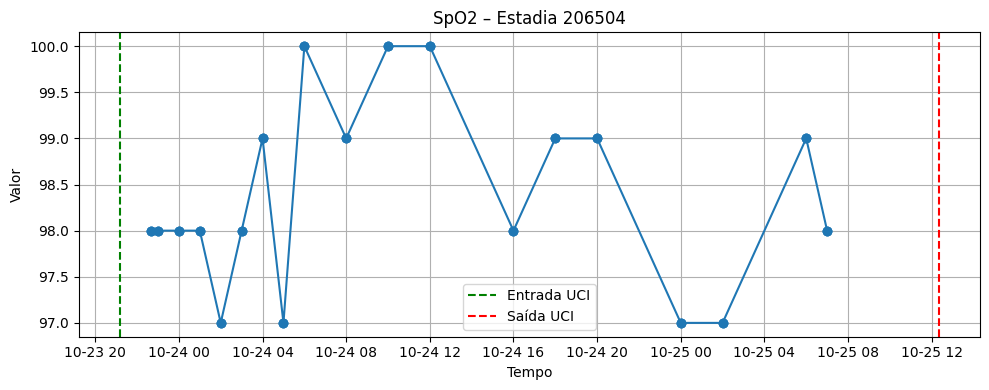

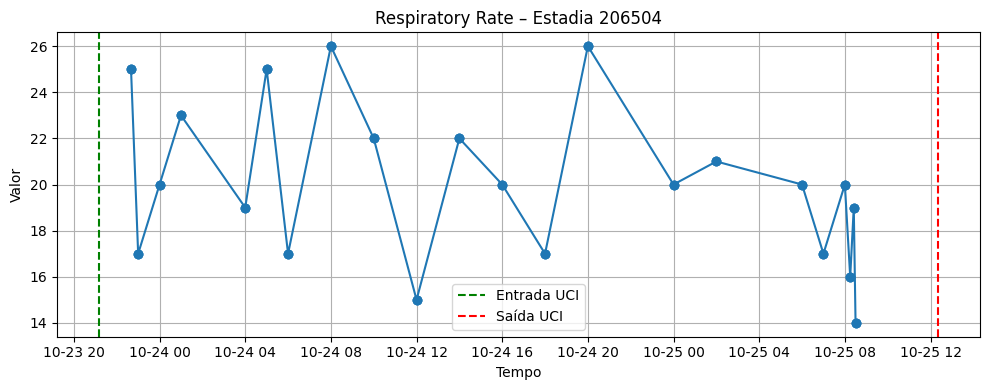

In [ ]:
# query="""
# SELECT
#   rf.CHARTTIME,
#   rf.VALUENUM,
#   rf.LABEL,
#   rf.ICUSTAY_ID
# FROM
#   `ml-pipeline-459822.data.raw_features` AS rf
# WHERE
#   rf.SUBJECT_ID = 10006
#   AND rf.LABEL IN ('Heart Rate', 'SpO2', 'Respiratory Rate', 'Temperature')
#   AND rf.VALUENUM IS NOT NULL
# ORDER BY
#   rf.CHARTTIME
# """

# df = bpd.read_gbq(query).to_pandas()

# query="""
# SELECT
#   ICUSTAY_ID,
#   INTIME,
#   OUTTIME
# FROM
#   `ml-pipeline-459822.data.icustays`
# WHERE
#   SUBJECT_ID = 10006
# """
# tempos_uci = bpd.read_gbq(query).to_pandas().set_index('ICUSTAY_ID')



# Lista de métricas a mostrar
metricas = ['Heart Rate', 'SpO2', 'Respiratory Rate', 'Temperature']
subject_id = 10006
estadias_uci = df['ICUSTAY_ID'].dropna().unique()

for icu_id in estadias_uci:
    df_icu = df[(df['ICUSTAY_ID'] == icu_id) & (df['LABEL'].isin(metricas))]

    if df_icu.empty or icu_id not in tempos_uci.index:
        continue

    intime = tempos_uci.loc[icu_id, 'INTIME']
    outtime = tempos_uci.loc[icu_id, 'OUTTIME']

    print(f"\n Curvas temporais – Paciente {subject_id} – Estadia {icu_id}")

    for metrica in metricas:
        dados = df_icu[df_icu['LABEL'] == metrica].sort_values('CHARTTIME')

        # Remoção de outliers
        if metrica == 'Respiratory Rate':
            dados = dados[dados['VALUENUM'] < 60]
        if metrica == 'Heart Rate':
            dados = dados[dados['VALUENUM'] < 200]

        if dados.empty:
            continue

        plt.figure(figsize=(10, 4))
        plt.plot(dados['CHARTTIME'], dados['VALUENUM'], marker='o', linestyle='-')
        plt.axvline(intime, color='green', linestyle='--', label='Entrada UCI')
        plt.axvline(outtime, color='red', linestyle='--', label='Saída UCI')
        plt.title(f"{metrica} – Estadia {icu_id}")
        plt.xlabel("Tempo")
        plt.ylabel("Valor")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

### One Full Day of Interventions for a Random Patient

/var/folders/2s/klc5jhq94c906gjssf2jnj7c0000gn/T/ipykernel_23221/3447118351.py:43: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


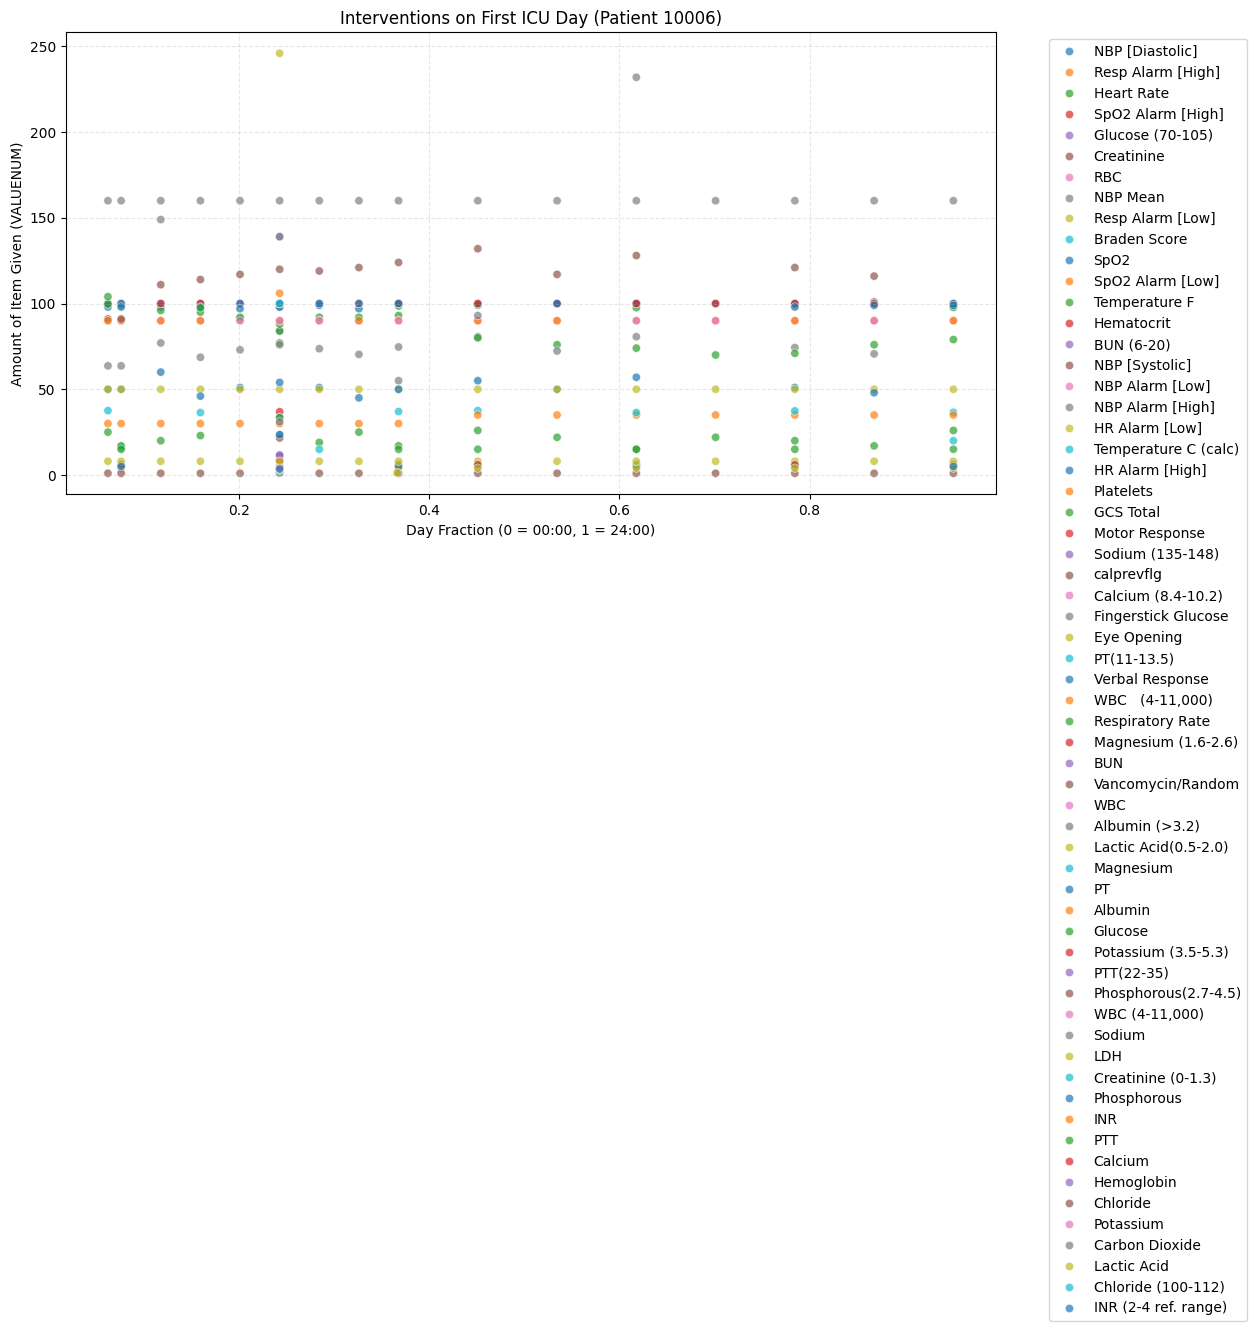

In [33]:
# 1. Query patient interventions over one ICU stay
query = """
SELECT
  ce.ICUSTAY_ID,
  ce.CHARTTIME,
  ce.ITEMID,
  ce.VALUENUM,
  d.LABEL,
  icu.INTIME
FROM
  `ml-pipeline-459822.data.chartevents` AS ce
JOIN
  `ml-pipeline-459822.data.d_items` AS d
  ON ce.ITEMID = d.ITEMID
JOIN
  `ml-pipeline-459822.data.icustays` AS icu
  ON ce.ICUSTAY_ID = icu.ICUSTAY_ID
WHERE
  ce.SUBJECT_ID = 10006
  AND ce.VALUENUM IS NOT NULL
LIMIT 10000
"""

# Run query
patient_data = bpd.read_gbq(query).to_pandas()

# Convert both to timezone-naive
patient_data['CHARTTIME'] = pd.to_datetime(patient_data['CHARTTIME']).dt.tz_localize(None)
patient_data['INTIME'] = pd.to_datetime(patient_data['INTIME']).dt.tz_localize(None)

patient_data['hours_since_start'] = (patient_data['CHARTTIME'] - patient_data['INTIME']).dt.total_seconds() / 3600
patient_data = patient_data[(patient_data['hours_since_start'] >= 0) & (patient_data['hours_since_start'] <= 24)]
patient_data['day_fraction'] = patient_data['hours_since_start'] / 24

# 3. Plot: Dot plot of interventions over the first ICU day
plt.figure(figsize=(12, 6))
sns.scatterplot(data=patient_data, x='day_fraction', y='VALUENUM', hue='LABEL', palette='tab10', legend='full', alpha=0.7)

plt.title("Interventions on First ICU Day (Patient 10006)")
plt.xlabel("Day Fraction (0 = 00:00, 1 = 24:00)")
plt.ylabel("Amount of Item Given (VALUENUM)")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

---

## **Specific Analysis**
[[ go back to the top ]](#Table-of-contents)

In this section, we will analyse the data in a more specific way, focusing primarily on the patients and their hospital admissions. The analysis that take part in this section are as follows:

- Patients analysis:
    - **Number of patients**: We will check how many patients are in the dataset.
    - **Disribution of patients by gender**: We will check the distribution of patients based on their gender.
    - **Average length of stay by gender**: We will check the average length of stay in the ICU based on the patients gender. 
    - **Main Diagnoses by gender**: We will check the main diagnoses based on the patients gender.
    - **Distribution of patients by the top 10 ethnicities**: We will check the distribution of patients based on the top 10 ethnicities.
    - **Distribution of patients by marital status**: We will check the distribution of patients based on their marital status.
    - **Distribution of patients by insurance**: We will check the distribution of patients based on their insurance.
    - **Distribution of patients by age**: We will check the distribution of patients based on their age.
    - **Average length of stay by age**: We will check the average length of stay in the ICU based on the patients age.

- Hospital admissions analysis:
    - **Number of Hospital Admissions**: We will check how many hospital admissions are in the dataset.
    - **Number of Patients by Admission Type**: We will check the number of patients based on the type of admission.
    - **Average Length of Stay by Admission Type**: We will check the average length of stay in the ICU based on the type of admission.
    - ***Hospital Admissions over time distribution**: We will check the distribution of hospital admissions over time.
    - **Hospital Mortality Rate by Admission Type**: We will check the hospital mortality rate based on the type of admission.
    - **Survival and Mortality Rate**: We will check the overall survival and mortality rate.





### **Patients Analysis**

### Number of Patients in the Dataset with the 5 most common diseases

In [38]:
raw_features['SUBJECT_ID'].nunique()

np.int64(28472)

### Distribution of Patients by Gender

/var/folders/2s/klc5jhq94c906gjssf2jnj7c0000gn/T/ipykernel_15639/1921277255.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=gender_df, x='GENDER', y='num_patients', palette=['#FF69B4', '#6495ED'])  # blue and pink


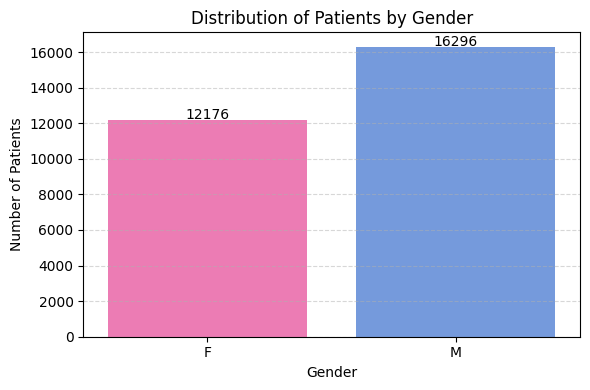

In [ ]:
# query_gender = """
# SELECT
#   GENDER,
#   COUNT(DISTINCT SUBJECT_ID) AS num_patients
# FROM
#   `ml-pipeline-459822.data.raw_features`
# WHERE
#   GENDER IS NOT NULL
# GROUP BY
#   GENDER
# ORDER BY
#   num_patients DESC
# """

# # Lê os dados da query
# gender_df = bpd.read_gbq(query_gender).to_pandas()

plt.figure(figsize=(6, 4))
sns.barplot(data=gender_df, x='GENDER', y='num_patients', palette=['#FF69B4', '#6495ED'])  # blue and pink

# Add counts above bars
for index, row in gender_df.iterrows():
    plt.text(index, row['num_patients'] + 50, int(row['num_patients']), ha='center')

plt.title("Distribution of Patients by Gender")
plt.xlabel("Gender")
plt.ylabel("Number of Patients")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Average Length of Stay by Gender

/var/folders/2s/klc5jhq94c906gjssf2jnj7c0000gn/T/ipykernel_30558/3529500070.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=los_gender_df, x='GENDER', y='avg_los', palette=['#FF69B4', '#6495ED'])


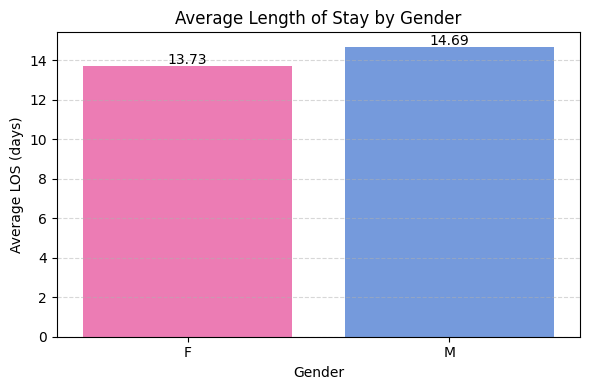

In [21]:
# query_los_gender = """
# SELECT
#   GENDER,
#   AVG(LOS) AS avg_los,
#   COUNT(DISTINCT SUBJECT_ID) AS num_patients
# FROM
#   `ml-pipeline-459822.data.raw_features`
# WHERE
#   GENDER IS NOT NULL AND LOS IS NOT NULL
# GROUP BY
#   GENDER
# ORDER BY
#   avg_los DESC
# """


# los_gender_df = bpd.read_gbq(query_los_gender).to_pandas()

# Plot da média de LOS por género
plt.figure(figsize=(6, 4))
sns.barplot(data=los_gender_df, x='GENDER', y='avg_los', palette=['#FF69B4', '#6495ED'])

# Adicionar valores acima das barras
for index, row in los_gender_df.iterrows():
    plt.text(index, row['avg_los'] + 0.1, f"{row['avg_los']:.2f}", ha='center')

plt.title("Average Length of Stay by Gender")
plt.xlabel("Gender")
plt.ylabel("Average LOS (days)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Main Diagnosis by Gender

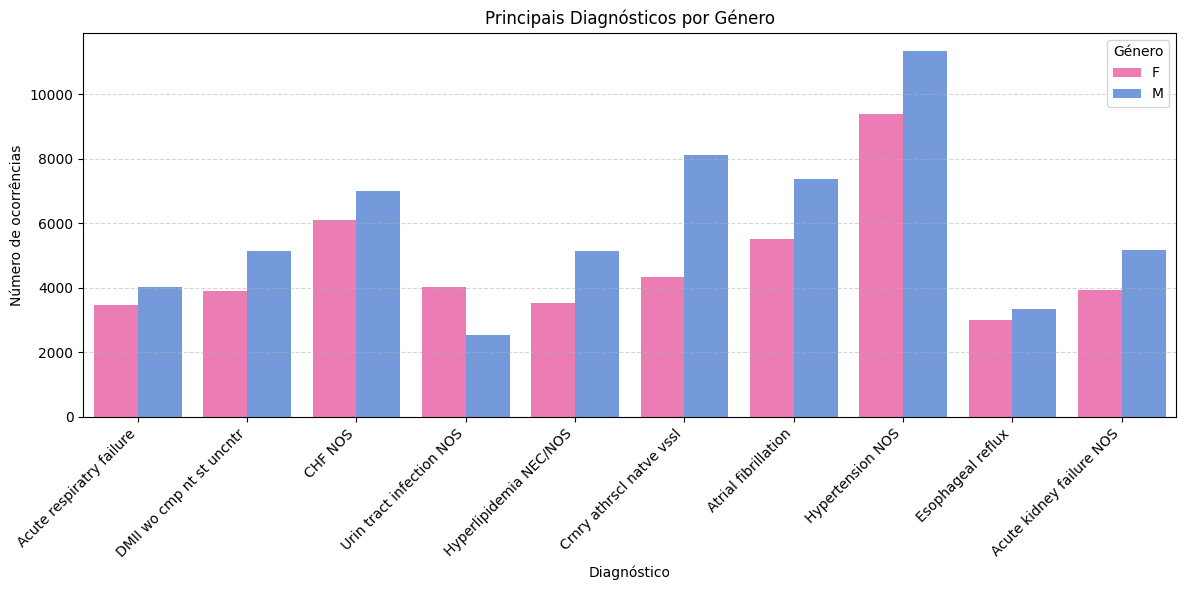

In [54]:
# query="""
# SELECT
#   p.GENDER,
#   dd.SHORT_TITLE AS diagnostico,
#   COUNT(*) AS num_ocorrencias
# FROM
#   `ml-pipeline-459822.data.diagnoses_icd` AS d
# JOIN
#   `ml-pipeline-459822.data.d_icd_diagnoses` AS dd
# ON
#   d.ICD9_CODE = dd.ICD9_CODE
# JOIN
#   `ml-pipeline-459822.data.patients` AS p
# ON
#   d.SUBJECT_ID = p.SUBJECT_ID
# WHERE
#   p.GENDER IN ('M', 'F')
# GROUP BY
#   p.GENDER, dd.SHORT_TITLE
# ORDER BY
#   num_ocorrencias DESC
# LIMIT 1000
# """

# # Lê os dados da query
# df = bpd.read_gbq(query).to_pandas()

# Filtra os 10 diagnósticos mais comuns por género
top_diagnosticos = (
    df.groupby('diagnostico')['num_ocorrencias'].sum()
    .nlargest(10)
    .index.tolist()
)

df_top = df[df['diagnostico'].isin(top_diagnosticos)]

# Gráfico
plt.figure(figsize=(12, 6))
sns.barplot(data=df_top, x='diagnostico', y='num_ocorrencias', hue='GENDER', palette=['#FF69B4', '#6495ED'])

plt.title("Principais Diagnósticos por Género")
plt.ylabel("Número de ocorrências")
plt.xlabel("Diagnóstico")
plt.xticks(rotation=45, ha='right')
plt.legend(title='Género')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

### Top 10 of the most etnicities appeared

/var/folders/2s/klc5jhq94c906gjssf2jnj7c0000gn/T/ipykernel_15639/259934976.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ethnicity_df, x='ETHNICITY', y='num_patients', palette='viridis')


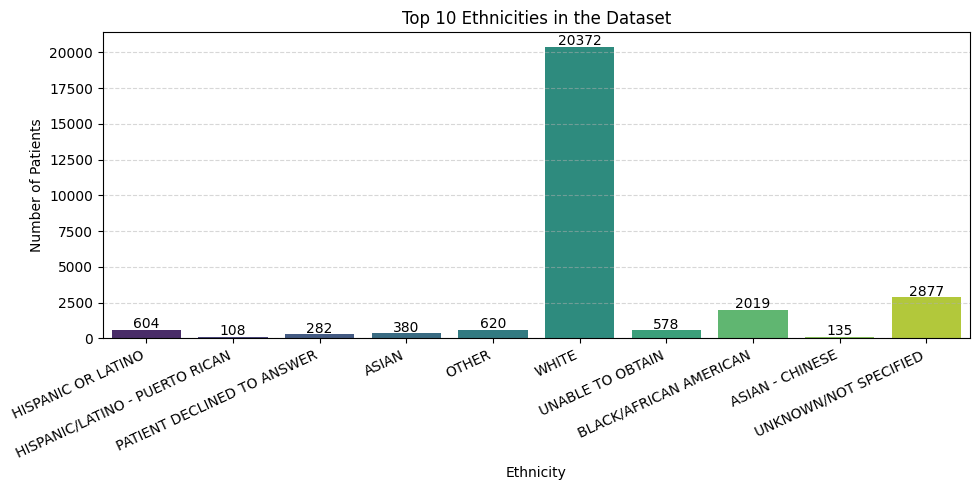

In [ ]:
# # Query para obter o top 10 de etnias com mais pacientes
# query_ethnicity = """
# SELECT
#   ETHNICITY,
#   COUNT(DISTINCT SUBJECT_ID) AS num_patients
# FROM
#   `ml-pipeline-459822.data.raw_features`
# WHERE
#   ETHNICITY IS NOT NULL
# GROUP BY
#   ETHNICITY
# ORDER BY
#   num_patients DESC
# LIMIT 10
# """

# # Lê os dados da query
# ethnicity_df = bpd.read_gbq(query_ethnicity).to_pandas()

# Plot das etnias mais frequentes
plt.figure(figsize=(10, 5))
sns.barplot(data=ethnicity_df, x='ETHNICITY', y='num_patients', palette='viridis')

# Adicionar valores acima das barras
for index, row in ethnicity_df.iterrows():
    plt.text(index, row['num_patients'] + 100, int(row['num_patients']), ha='center')

plt.title("Top 10 Ethnicities in the Dataset")
plt.xlabel("Ethnicity")
plt.ylabel("Number of Patients")
plt.xticks(rotation=25, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Top 10 of the most marital statuses appeared

/var/folders/2s/klc5jhq94c906gjssf2jnj7c0000gn/T/ipykernel_15639/1013712401.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=marital_df, x='MARITAL_STATUS', y='num_patients', palette='coolwarm')


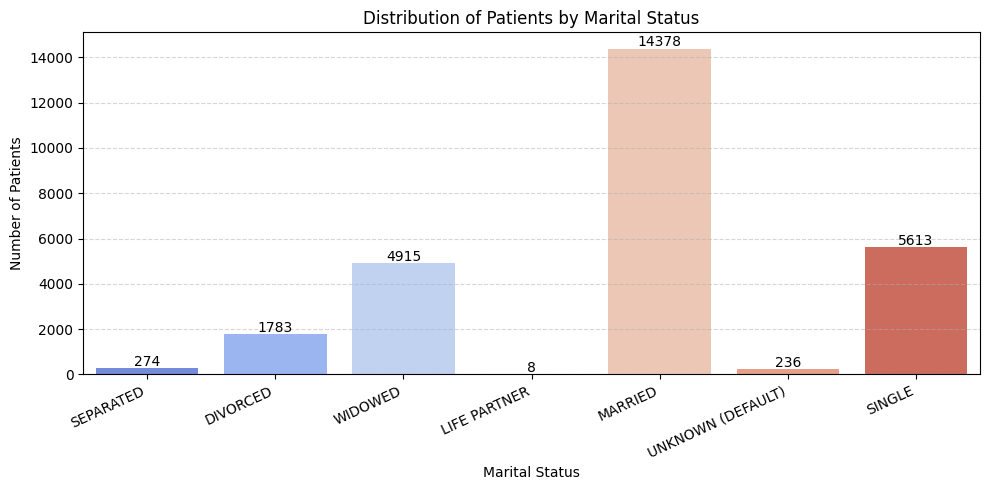

In [56]:
# # Query para obter o número de pacientes por estado civil
# query_marital = """
# SELECT
#   MARITAL_STATUS,
#   COUNT(DISTINCT SUBJECT_ID) AS num_patients
# FROM
#   `ml-pipeline-459822.data.raw_features`
# WHERE
#   MARITAL_STATUS IS NOT NULL
# GROUP BY
#   MARITAL_STATUS
# ORDER BY
#   num_patients DESC
# """

# # Lê os dados da query
# marital_df = bpd.read_gbq(query_marital).to_pandas()

# Plot do estado civil dos pacientes
plt.figure(figsize=(10, 5))
sns.barplot(data=marital_df, x='MARITAL_STATUS', y='num_patients', palette='coolwarm')

# Adicionar valores acima das barras
for index, row in marital_df.iterrows():
    plt.text(index, row['num_patients'] + 100, int(row['num_patients']), ha='center')

plt.title("Distribution of Patients by Marital Status")
plt.xlabel("Marital Status")
plt.ylabel("Number of Patients")
plt.xticks(rotation=25, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Most frequent insurance types appeared

/var/folders/2s/klc5jhq94c906gjssf2jnj7c0000gn/T/ipykernel_15639/2522397343.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=insurance_df, x='INSURANCE', y='num_patients', palette='Set2')


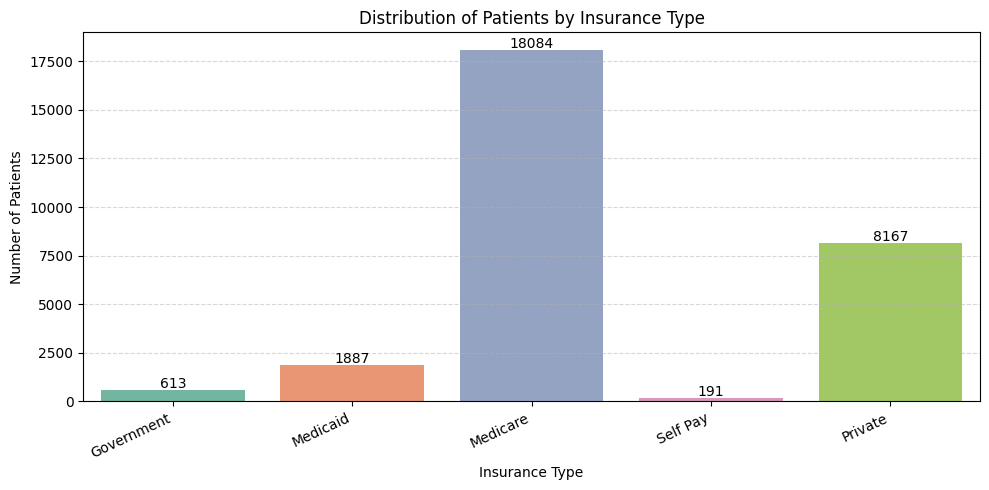

In [ ]:
# # Query to get number of patients per insurance type
# query_insurance = """
# SELECT
#   INSURANCE,
#   COUNT(DISTINCT SUBJECT_ID) AS num_patients
# FROM
#   `ml-pipeline-459822.data.raw_features`
# WHERE
#   INSURANCE IS NOT NULL
# GROUP BY
#   INSURANCE
# ORDER BY
#   num_patients DESC
# """

# # Load the data into a DataFrame
# insurance_df = bpd.read_gbq(query_insurance).to_pandas()

# Plotting the distribution
plt.figure(figsize=(10, 5))
sns.barplot(data=insurance_df, x='INSURANCE', y='num_patients', palette='Set2')

# Add count labels above bars
for index, row in insurance_df.iterrows():
    plt.text(index, row['num_patients'] + 100, int(row['num_patients']), ha='center')

plt.title("Distribution of Patients by Insurance Type")
plt.xlabel("Insurance Type")
plt.ylabel("Number of Patients")
plt.xticks(rotation=25, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Distribution of Patients by Age

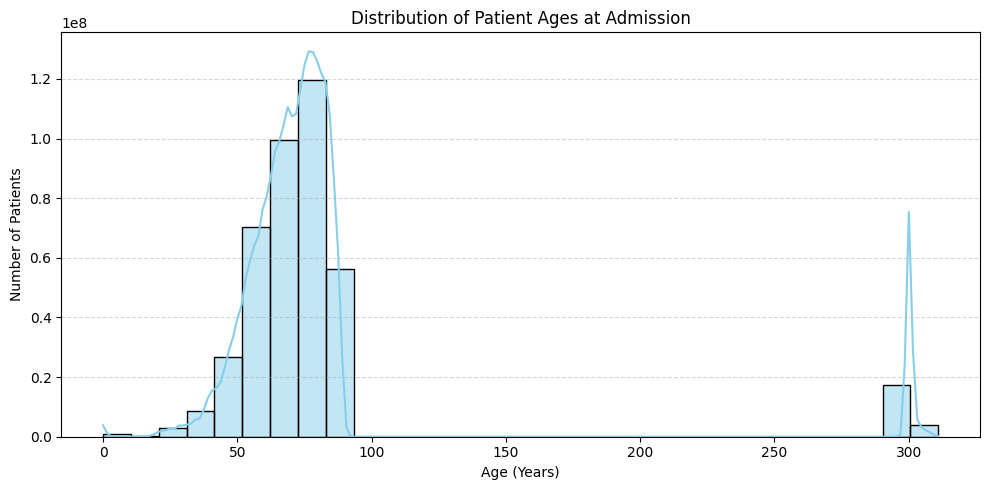

In [ ]:
# # Calculate patient age at the time of admission
# query_age = """
# SELECT
#   SUBJECT_ID,
#   DATE_DIFF(DATE(ADMITTIME), DATE(DOB), YEAR) AS AGE
# FROM
#   `ml-pipeline-459822.data.raw_features`
# WHERE
#   DOB IS NOT NULL AND ADMITTIME IS NOT NULL
# """

# # Load data into a DataFrame
# age_df = bpd.read_gbq(query_age).to_pandas()

# Plotting age distribution
plt.figure(figsize=(10, 5))
sns.histplot(data=age_df, x='AGE', bins=30, kde=True, color='darkblue')

plt.title("Distribution of Patient Ages at Admission")
plt.xlabel("Age (Years)")
plt.ylabel("Number of Patients")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Some age values appear around 300 years, which is not realistic. This probably happens because, in the MIMIC-III dataset, the date of birth is artificially shifted for patients over 89 years old to protect their privacy. As a result, their age is calculated as very high (often around 300). These entries should considered as outliers and therefore excluded or grouped as “90+”.


### Average Length of Stay by Age

Pearson correlation between Age and ICU Length of Stay: -0.0937


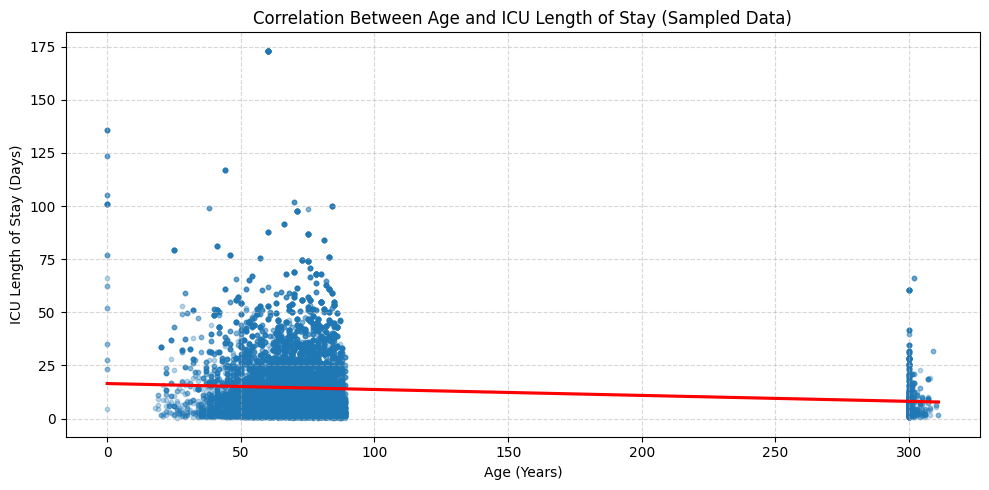

In [ ]:
# # Query to retrieve age and LOS
# query_correlation = """
# SELECT
#   SUBJECT_ID,
#   DATE_DIFF(DATE(ADMITTIME), DATE(DOB), YEAR) AS AGE,
#   LOS
# FROM
#   `ml-pipeline-459822.data.raw_features`
# WHERE
#   DOB IS NOT NULL AND ADMITTIME IS NOT NULL AND LOS IS NOT NULL
# """

# # Load data
# correlation_df = bpd.read_gbq(query_correlation).to_pandas()

# Drop any rows with missing values just in case
correlation_df = correlation_df.dropna(subset=['AGE', 'LOS'])


# Usar só 20 mil linhas aleatórias para o plot
sample_df = correlation_df.sample(n=100000, random_state=42)

# Calculate Pearson correlation coefficient
correlation = sample_df['AGE'].corr(sample_df['LOS'])

# Display the correlation value
print(f"Pearson correlation between Age and ICU Length of Stay: {correlation:.4f}")


plt.figure(figsize=(10, 5))
sns.regplot(data=sample_df, x='AGE', y='LOS', scatter_kws={'alpha':0.3, 's':10}, line_kws={'color':'red'})
plt.title("Correlation Between Age and ICU Length of Stay (Sampled Data)")
plt.xlabel("Age (Years)")
plt.ylabel("ICU Length of Stay (Days)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## DEMORA BUE A CORRER

In [29]:
# Query to retrieve age and LOS
query_correlation = """
SELECT
  SUBJECT_ID,
  DATE_DIFF(DATE(ADMITTIME), DATE(DOB), YEAR) AS AGE,
  LOS
FROM
  `ml-pipeline-459822.data.raw_features`
WHERE
  DOB IS NOT NULL AND ADMITTIME IS NOT NULL AND LOS IS NOT NULL
"""

# Load the data from BigQuery using pandas_gbq
correlation_df = pandas_gbq.read_gbq(query_correlation, project_id="ml-pipeline-459822")

# Drop any rows with missing values (just in case)
correlation_df = correlation_df.dropna(subset=['AGE', 'LOS'])

# Optional: Filter out invalid or extreme values (sanity check)
correlation_df = correlation_df[(correlation_df['AGE'] > 0) & (correlation_df['AGE'] < 120)]
correlation_df = correlation_df[(correlation_df['LOS'] > 0) & (correlation_df['LOS'] < 100)]

# Sample 100,000 rows for plotting (for speed and clarity)
sample_df = correlation_df.sample(n=100000, random_state=42)

# Calculate Pearson correlation coefficient
correlation = sample_df['AGE'].corr(sample_df['LOS'])
print(f"Pearson correlation between Age and ICU Length of Stay: {correlation:.4f}")

# Plot with regression line
plt.figure(figsize=(10, 5))
sns.regplot(
    data=sample_df, 
    x='AGE', 
    y='LOS', 
    scatter_kws={'alpha': 0.3, 's': 10},   # light dots
    line_kws={'color': 'red'}             # red regression line
)

plt.title("Correlation Between Age and ICU Length of Stay (Sampled Data)")
plt.xlabel("Age (Years)")
plt.ylabel("ICU Length of Stay (Days)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

/var/folders/2s/klc5jhq94c906gjssf2jnj7c0000gn/T/ipykernel_30558/935923748.py:14: LargeResultsWarning: Recommendation: Your results are 9.1 GiB. Consider using BigQuery DataFrames (https://bit.ly/bigframes-intro)to process large results with pandas compatible APIs with transparent SQL pushdown to BigQuery engine. This provides an opportunity to save on costs and improve performance. Please reach out to bigframes-feedback@google.com with any questions or concerns. To disable this message, run warnings.simplefilter('ignore', category=pandas_gbq.exceptions.LargeResultsWarning)
  correlation_df = pandas_gbq.read_gbq(query_correlation, project_id="ml-pipeline-459822")


Downloading:  13%|█▎        |

KeyboardInterrupt: 

### **Hospital Admissions Analysis**

### Number of Hospital Admissions in the Dataset with the 5 most common diseases

In [16]:
raw_features['HADM_ID'].nunique()

np.int64(35918)

### Number of Patients by Admission Type

/var/folders/2s/klc5jhq94c906gjssf2jnj7c0000gn/T/ipykernel_18416/1921620465.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pacientes_por_admissao_df, x='ADMISSION_TYPE', y='num_pacientes', palette='Blues_d')


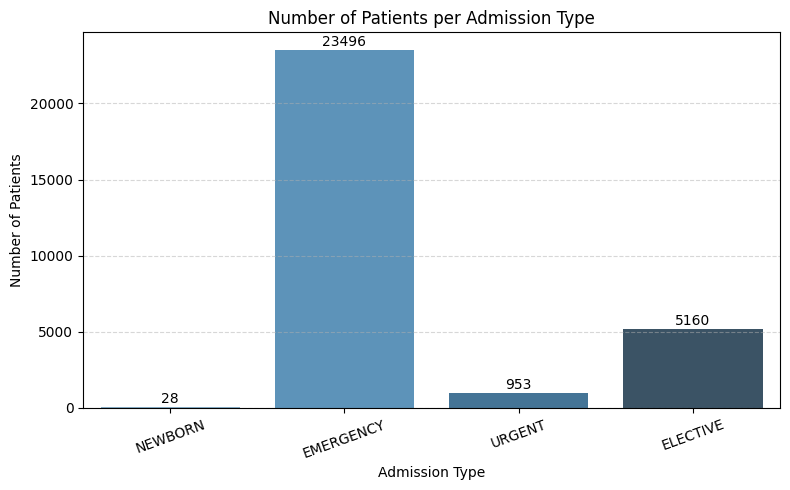

In [ ]:
# # Query para contar o número de pacientes distintos por tipo de admissão
# query_pacientes_por_admissao = """
# SELECT
#   ADMISSION_TYPE,
#   COUNT(DISTINCT SUBJECT_ID) AS num_pacientes
# FROM
#   `ml-pipeline-459822.data.raw_features`
# WHERE
#   ADMISSION_TYPE IS NOT NULL
# GROUP BY
#   ADMISSION_TYPE
# ORDER BY
#   num_pacientes DESC
# """

# # Lê os dados da query
# pacientes_por_admissao_df = bpd.read_gbq(query_pacientes_por_admissao).to_pandas()

# Plot do número de pacientes por tipo de admissão
plt.figure(figsize=(8, 5))
sns.barplot(data=pacientes_por_admissao_df, x='ADMISSION_TYPE', y='num_pacientes', palette='Blues_d')

# Adicionar contagens
for index, row in pacientes_por_admissao_df.iterrows():
    plt.text(index, row['num_pacientes'] + 100, int(row['num_pacientes']), ha='center', va='bottom')

plt.title("Number of Patients per Admission Type")
plt.xlabel("Admission Type")
plt.ylabel("Number of Patients")
plt.xticks(rotation=20)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Average Length of Stay by Admission Type

/var/folders/2s/klc5jhq94c906gjssf2jnj7c0000gn/T/ipykernel_18904/2189661857.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=los_admission_df, x='ADMISSION_TYPE', y='avg_los', palette='Blues_d')


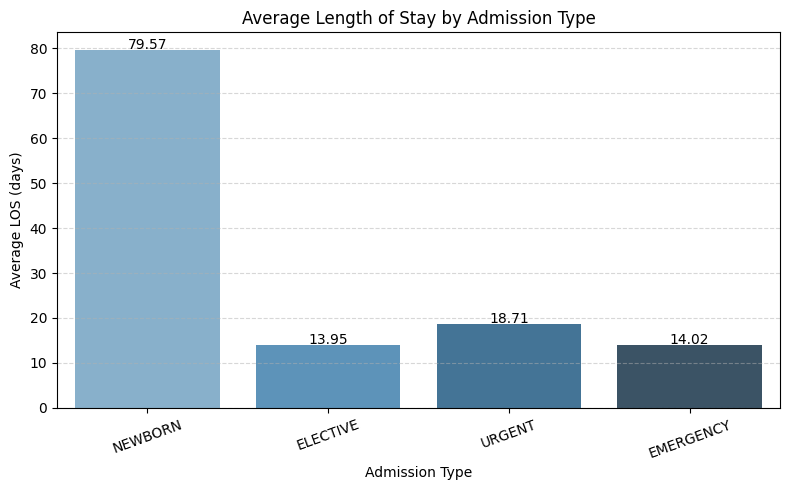

In [ ]:
# # Query para calcular o LOS médio por tipo de admissão
# query_los_admission = """
# SELECT
#   ADMISSION_TYPE,
#   AVG(LOS) AS avg_los
# FROM
#   `ml-pipeline-459822.data.raw_features`
# WHERE
#   ADMISSION_TYPE IS NOT NULL AND LOS IS NOT NULL
# GROUP BY
#   ADMISSION_TYPE
# ORDER BY
#   avg_los DESC
# """

# # Lê os dados da query
# los_admission_df = bpd.read_gbq(query_los_admission).to_pandas()

# Plot do LOS médio por tipo de admissão
plt.figure(figsize=(8, 5))
sns.barplot(data=los_admission_df, x='ADMISSION_TYPE', y='avg_los', palette='Blues_d')

# Adicionar valores acima das barras
for index, row in los_admission_df.iterrows():
    plt.text(index, row['avg_los'] + 0.2, round(row['avg_los'], 2), ha='center')

plt.title("Average Length of Stay by Admission Type")
plt.xlabel("Admission Type")
plt.ylabel("Average LOS (days)")
plt.xticks(rotation=20)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Hospital Admissions over time distribution

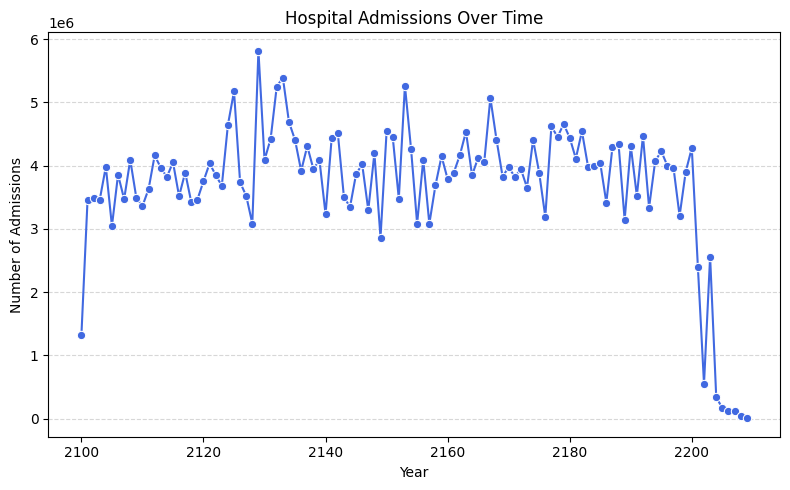

In [ ]:
# query = """
# SELECT
#   EXTRACT(YEAR FROM ADMITTIME) AS year,
#   COUNT(*) AS admissions
# FROM
#   `ml-pipeline-459822.data.raw_features`
# GROUP BY
#   year
# ORDER BY
#   year
# """

# admissions_over_time = bpd.read_gbq(query).to_pandas()

plt.figure(figsize=(8, 5))
sns.lineplot(data=admissions_over_time, x='year', y='admissions', marker='o', color='royalblue')
plt.title("Hospital Admissions Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Admissions")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Hospital Mortality Rate by Admission Type

/var/folders/2s/klc5jhq94c906gjssf2jnj7c0000gn/T/ipykernel_18416/1963936492.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mortalidade_adm_df, x='ADMISSION_TYPE', y='taxa_mortalidade', palette='Reds')


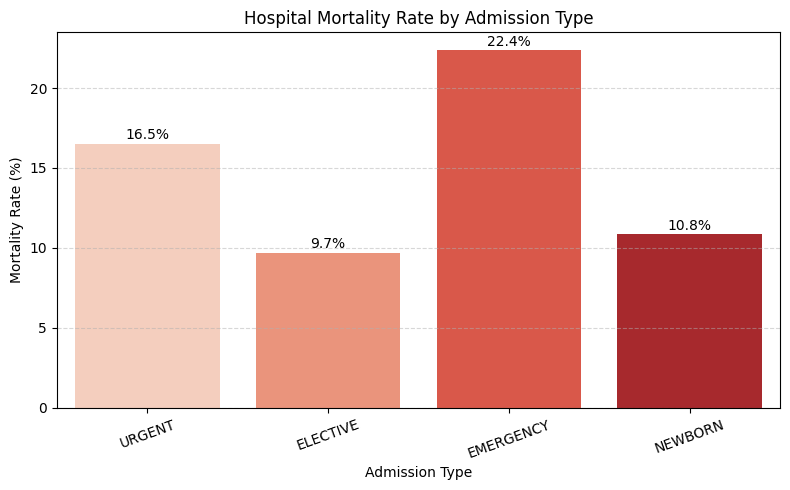

In [20]:
# # Query para calcular a taxa de mortalidade por tipo de admissão
# query_mortalidade_admissao = """
# SELECT
#   ADMISSION_TYPE,
#   COUNT(*) AS total_admissoes,
#   SUM(HOSPITAL_EXPIRE_FLAG) AS total_obitos,
#   SAFE_DIVIDE(SUM(HOSPITAL_EXPIRE_FLAG), COUNT(*)) * 100 AS taxa_mortalidade
# FROM
#   `ml-pipeline-459822.data.raw_features`
# WHERE
#   ADMISSION_TYPE IS NOT NULL
# GROUP BY
#   ADMISSION_TYPE
# ORDER BY
#   taxa_mortalidade DESC
# """

# # Lê os dados da query
# mortalidade_adm_df = bpd.read_gbq(query_mortalidade_admissao).to_pandas()

# Plot da taxa de mortalidade por tipo de admissão
plt.figure(figsize=(8, 5))
sns.barplot(data=mortalidade_adm_df, x='ADMISSION_TYPE', y='taxa_mortalidade', palette='Reds')

# Adicionar valores
for index, row in mortalidade_adm_df.iterrows():
    plt.text(index, row['taxa_mortalidade'] + 0.1, f"{row['taxa_mortalidade']:.1f}%", ha='center', va='bottom')

plt.title("Hospital Mortality Rate by Admission Type")
plt.xlabel("Admission Type")
plt.ylabel("Mortality Rate (%)")
plt.xticks(rotation=20)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Survival and Mortality Rate 

/var/folders/2s/klc5jhq94c906gjssf2jnj7c0000gn/T/ipykernel_18904/668614132.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=surv_death_df, x='Status', y='count', palette=["Red", "Blue"])


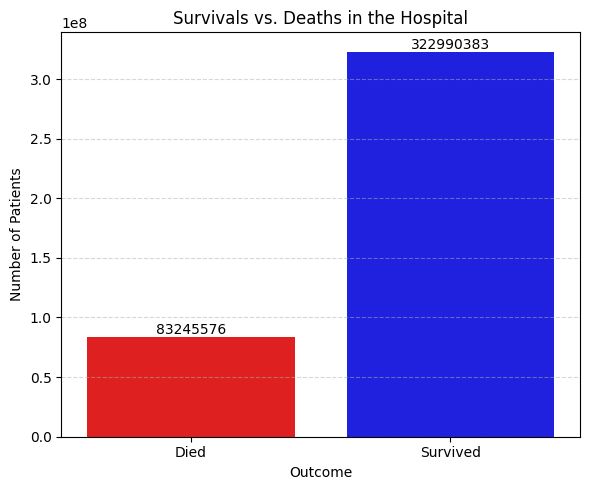

In [ ]:
# # Query para contar sobreviventes e óbitos
# query_surv_death = """
# SELECT
#   HOSPITAL_EXPIRE_FLAG,
#   COUNT(*) AS count
# FROM
#   `ml-pipeline-459822.data.raw_features`
# GROUP BY
#   HOSPITAL_EXPIRE_FLAG
# """

# # Lê os dados da query
# surv_death_df = bpd.read_gbq(query_surv_death).to_pandas()

# Traduz os valores 0 e 1
surv_death_df['Status'] = surv_death_df['HOSPITAL_EXPIRE_FLAG'].map({0: 'Survived', 1: 'Died'})

# Plot
plt.figure(figsize=(6, 5))
sns.barplot(data=surv_death_df, x='Status', y='count', palette=["Red", "Blue"])

# Adicionar valores
for index, row in surv_death_df.iterrows():
    plt.text(index, row['count'] + 500, int(row['count']), ha='center', va='bottom')

plt.title("Survivals vs. Deaths in the Hospital")
plt.xlabel("Outcome")
plt.ylabel("Number of Patients")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

---
---
# ** START FROM HERE **
---
---

# Preprocessing and Feature Engineering

[[ go back to the top ]](#Table-of-contents)

INTRO EXPLAINING THE PREPROCESSING AND FEATURE ENGINEERING STEPS
ONE PREPROCESSING USING BIGFRAMES.PANDAS WITH BIGQUERY AND ONE USING DASK 

## Preprocessing with Dask

In [30]:
import time
# Timing Dask preprocessing
start_time_dask = time.time()

In [31]:
import dask.dataframe as dd
import pandas_gbq

### Initially, we tried to load the entire raw_features table directly into memory using bpd.read_gbq(), but the query failed because the response size exceeded BigQuery’s limit for interactive queries (GenericGBQException: Reason: 403 GET ... Response too large to return. Consider specifying a destination table in your job configuration. For more details, see ...). To solve this, we limit the data to 100,000 rows using the LIMIT clause in our SQL query. This allowed us to work with a manageable subset of the data while still being able to perform our analysis and preprocessing steps.

Unrunable code bellow to see the error message.

In [32]:
# df_pandas = pandas_gbq.read_gbq("SELECT * FROM `ml-pipeline-459822.data.raw_features`")

In [33]:
# Read from BigQuery into Pandas first
df_pandas = pandas_gbq.read_gbq("SELECT * FROM `ml-pipeline-459822.data.raw_features` LIMIT 100000")

Downloading: 100%|██████████|


In [ ]:
load_time_dask = time.time() - start_time_dask
print(f"Time taken to load data into Pandas: {load_time_dask:.2f} seconds")

### Why pandas_gbq and not bpd?? - using bpd.read_gbq() to load data from BigQuery, returns a BigFrames DataFrame, which is not directly compatible with libraries like Dask or PySpark. Since dd.from_pandas() specifically expects a standard pandas DataFrame, we switched to pandas_gbq to load the data as a native pandas DataFrame, making it easier to integrate with other Python data processing tools. (TypeError: Input must be a pandas DataFrame or Series.)

Unrunable code bellow to see the error message.

In [34]:
# Convert to Dask
df_dask = dd.from_pandas(df_pandas, npartitions=4)

In [35]:
# df = bpd.read_gbq("SELECT * FROM `ml-pipeline-459822.data.raw_features` LIMIT 100000")
# df_dask = dd.from_pandas(df_pandas2, npartitions=4)


In [36]:
# Now use Dask for parallel computation
df_dask.info()

<class 'dask.dataframe.dask_expr.DataFrame'>
Columns: 28 entries, SUBJECT_ID to SEQ_NUM
dtypes: Int64(8), datetime64[us, UTC](5), datetime64[us](1), float64(2), string(12)

In [37]:
df_dask

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,CHARTTIME,VALUEUOM,DOB,ADMITTIME,DISCHTIME,DEATHTIME,HOSPITAL_EXPIRE_FLAG,ADMISSION_TYPE,GENDER,ETHNICITY,RELIGION,LANGUAGE,MARITAL_STATUS,INSURANCE,ITEMID,LABEL,CATEGORY,VALUE,VALUENUM,WARNING,ERROR,INTIME,LOS,ICD9_CODE,SEQ_NUM
npartitions=4,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,Int64,Int64,Int64,datetime64[us],string,"datetime64[us, UTC]","datetime64[us, UTC]","datetime64[us, UTC]","datetime64[us, UTC]",Int64,string,string,string,string,string,string,string,Int64,string,string,string,float64,Int64,Int64,"datetime64[us, UTC]",float64,string,Int64
25000,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50000,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75000,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99999,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


### Number of unique patients

In [38]:
df_dask['SUBJECT_ID'].nunique().compute()

np.int64(8424)

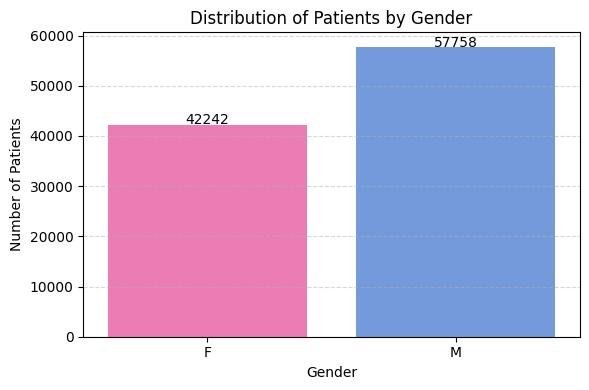

In [39]:
# Group by gender and count
gender_dask = df_dask.groupby("GENDER")["SUBJECT_ID"].count().reset_index()
gender_dask = gender_dask.rename(columns={"SUBJECT_ID": "num_patients"})

# Compute the result (this triggers Dask computation)
gender_df = gender_dask.compute()


plt.figure(figsize=(6, 4))
sns.barplot(data=gender_df, x='GENDER', y='num_patients', palette=['#FF69B4', '#6495ED'])

# Add counts above bars
for index, row in gender_df.iterrows():
    plt.text(index, row['num_patients'] + 50, int(row['num_patients']), ha='center')

plt.title("Distribution of Patients by Gender")
plt.xlabel("Gender")
plt.ylabel("Number of Patients")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

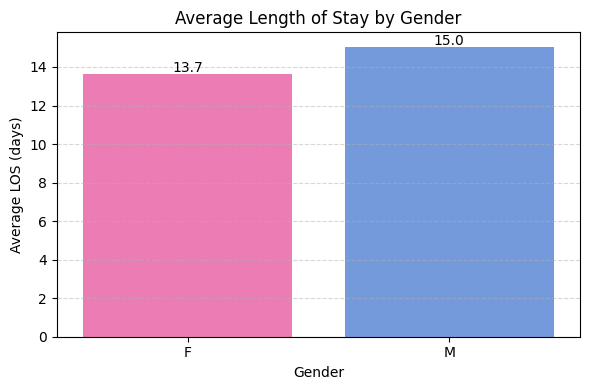

In [40]:
# Group by gender and calculate mean LOS
los_by_gender_dask = df_dask.groupby("GENDER")["LOS"].mean().reset_index()
los_by_gender_dask = los_by_gender_dask.rename(columns={"LOS": "avg_los"})

# Trigger computation
los_by_gender_df = los_by_gender_dask.compute()

plt.figure(figsize=(6, 4))
sns.barplot(data=los_by_gender_df, x='GENDER', y='avg_los', palette=['#FF69B4', '#6495ED'])

# Add values above bars
for index, row in los_by_gender_df.iterrows():
    plt.text(index, row['avg_los'] + 0.1, round(row['avg_los'], 1), ha='center')

plt.title("Average Length of Stay by Gender")
plt.xlabel("Gender")
plt.ylabel("Average LOS (days)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

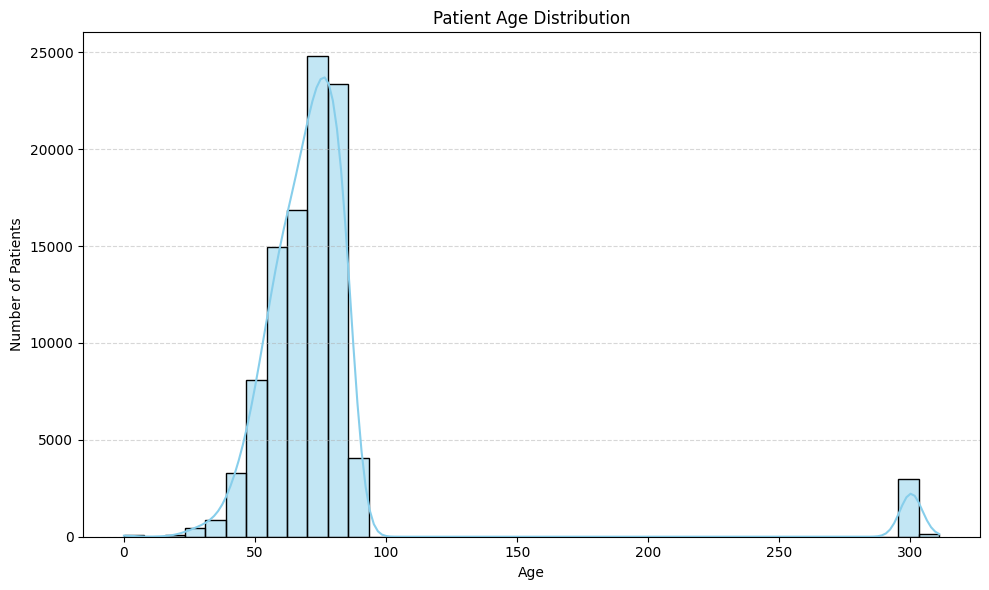

In [41]:
# Make sure columns are datetime
df_dask["ADMITTIME"] = dd.to_datetime(df_dask["ADMITTIME"])
df_dask["DOB"] = dd.to_datetime(df_dask["DOB"])

# Compute age in years (floor division)
df_dask["AGE"] = (df_dask["ADMITTIME"].dt.year - df_dask["DOB"].dt.year)

# Compute histogram data in Pandas
age_df = df_dask[["AGE"]].dropna().compute()

plt.figure(figsize=(10, 6))
sns.histplot(age_df["AGE"], bins=40, kde=True, color='skyblue')

plt.title("Patient Age Distribution")
plt.xlabel("Age")
plt.ylabel("Number of Patients")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

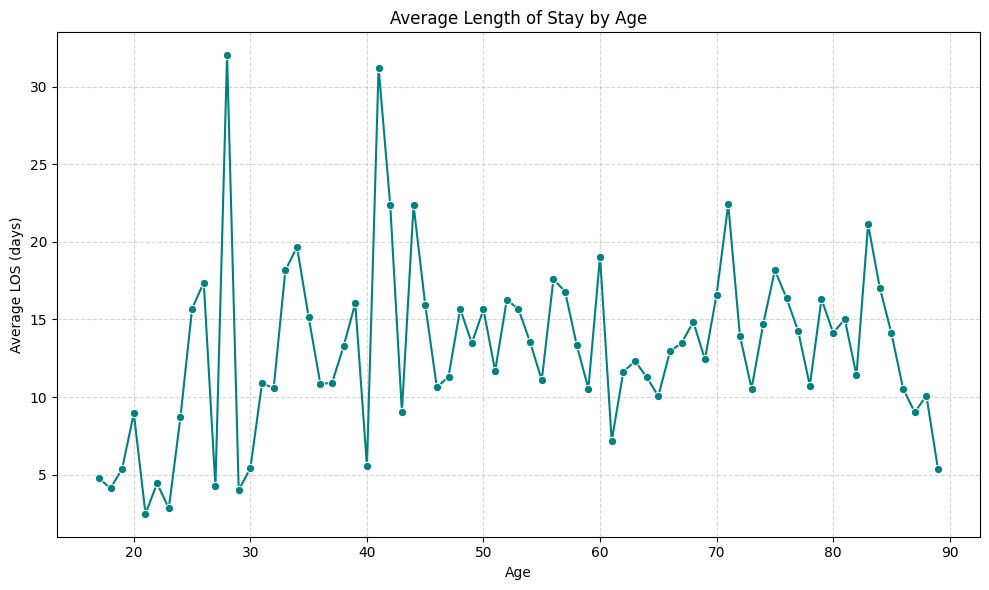

In [42]:
# Group by AGE and calculate average LOS
age_avg_los = df_dask[["AGE", "LOS"]].dropna()
age_avg_los = age_avg_los[(age_avg_los["AGE"] > 0) & (age_avg_los["AGE"] < 120)]
age_avg_los = age_avg_los[age_avg_los["LOS"] > 0]

# Group and compute
avg_los_by_age = age_avg_los.groupby("AGE")["LOS"].mean().compute().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=avg_los_by_age, x="AGE", y="LOS", marker='o', color="teal")

plt.title("Average Length of Stay by Age")
plt.xlabel("Age")
plt.ylabel("Average LOS (days)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

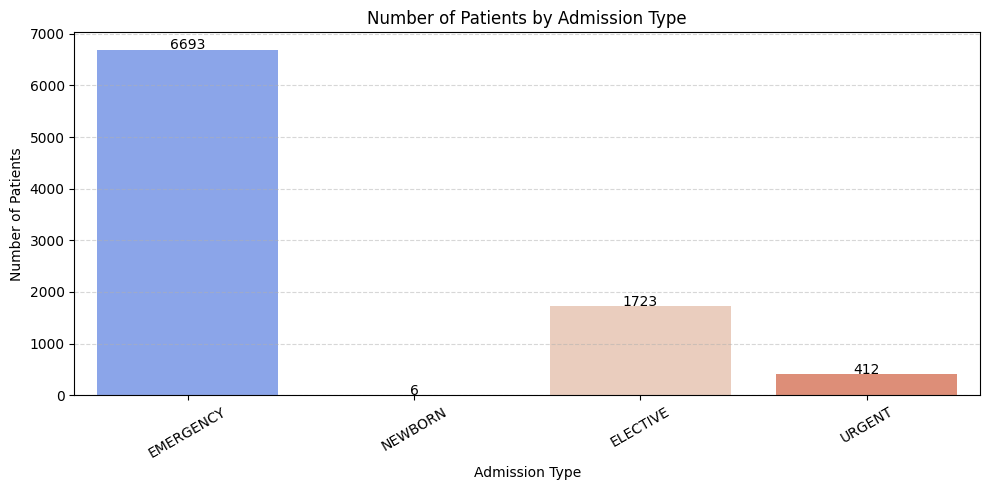

In [43]:
# Select relevant columns and drop nulls
patients_adm_dask = df_dask[["SUBJECT_ID", "ADMISSION_TYPE"]].dropna()

# Count distinct patients per admission type
patients_count = patients_adm_dask.groupby("ADMISSION_TYPE")["SUBJECT_ID"].nunique().compute().reset_index()

# Rename columns for clarity
patients_count.columns = ["ADMISSION_TYPE", "num_patients"]

plt.figure(figsize=(10, 5))
sns.barplot(data=patients_count, x="ADMISSION_TYPE", y="num_patients", palette="coolwarm")

# Add counts above bars
for index, row in patients_count.iterrows():
    plt.text(index, row['num_patients'] + 5, int(row['num_patients']), ha='center')

plt.title("Number of Patients by Admission Type")
plt.xlabel("Admission Type")
plt.ylabel("Number of Patients")
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

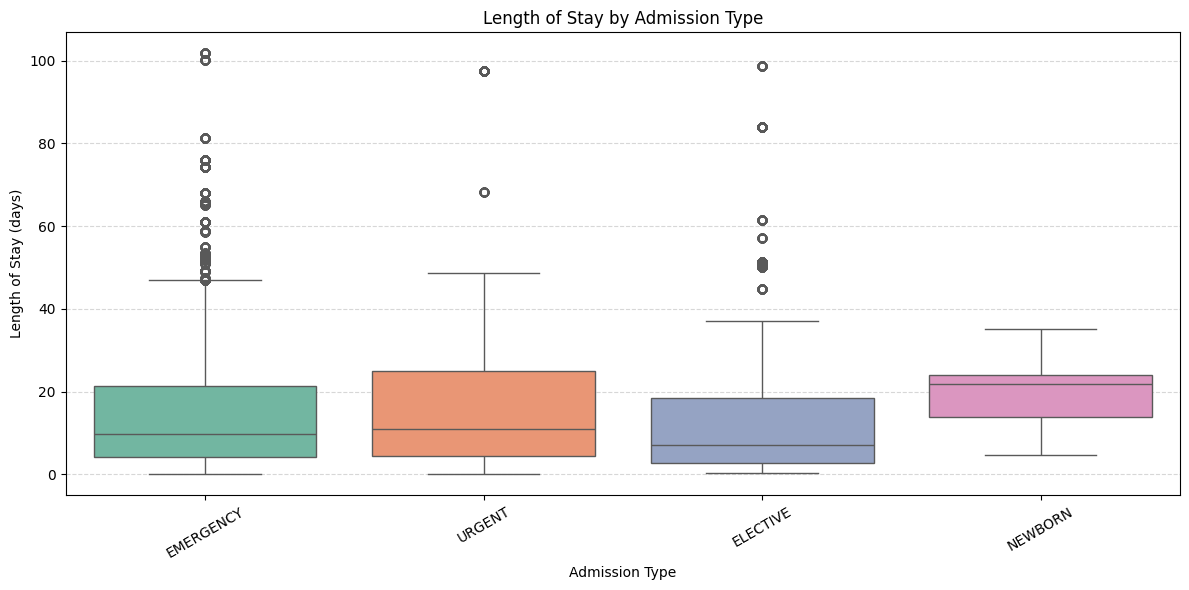

In [44]:
# Filter out nulls in ADMISSION_TYPE and LOS
admission_los_dask = df_dask[["ADMISSION_TYPE", "LOS"]].dropna()

# Optional: Filter out non-positive LOS values
admission_los_dask = admission_los_dask[admission_los_dask["LOS"] > 0]

# Compute into pandas DataFrame for plotting
admission_los_df = admission_los_dask.compute()

plt.figure(figsize=(12, 6))
sns.boxplot(data=admission_los_df, x="ADMISSION_TYPE", y="LOS", palette="Set2")

plt.title("Length of Stay by Admission Type")
plt.xlabel("Admission Type")
plt.ylabel("Length of Stay (days)")
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

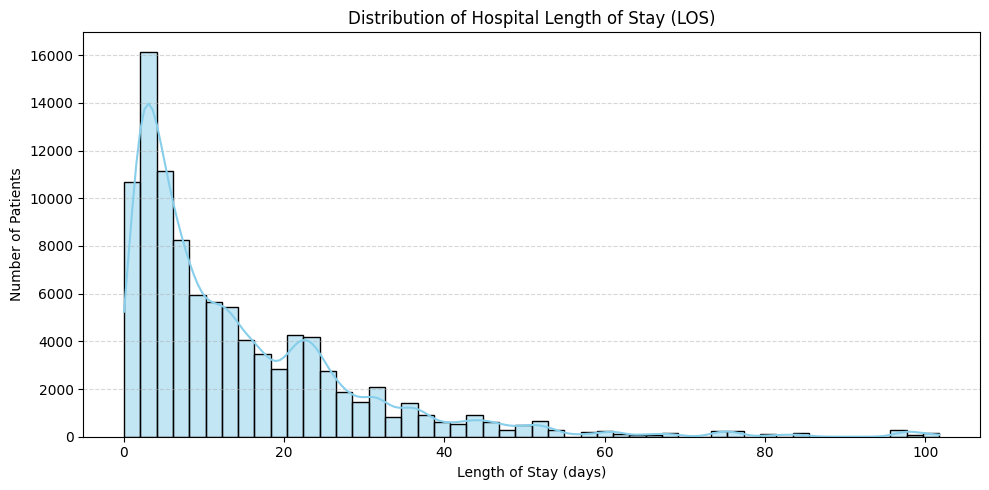

In [45]:
# Select LOS column and drop nulls
los_data = df_dask["LOS"].dropna().compute()

plt.figure(figsize=(10, 5))
sns.histplot(los_data, bins=50, kde=True, color='skyblue')

plt.title("Distribution of Hospital Length of Stay (LOS)")
plt.xlabel("Length of Stay (days)")
plt.ylabel("Number of Patients")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [46]:
end_time_dask = time.time()
dask_duration = end_time_dask - start_time_dask
print(f"Dask preprocessing time: {dask_duration:.2f} seconds")

Dask preprocessing time: 18.70 seconds


---
---
# ** START FROM HERE **
---
---

## Preprocessing with bigframes.pandas (BigQuery)

In [ ]:
# Timing BigQuery preprocessing
start_time_bq = time.time()

In [ ]:
end_time_bq = time.time()
bq_duration = end_time_bq - start_time_bq
print(f"BigQuery preprocessing time: {bq_duration:.2f} seconds")

## Comparing the two approaches by time taken to run the same preprocessing steps

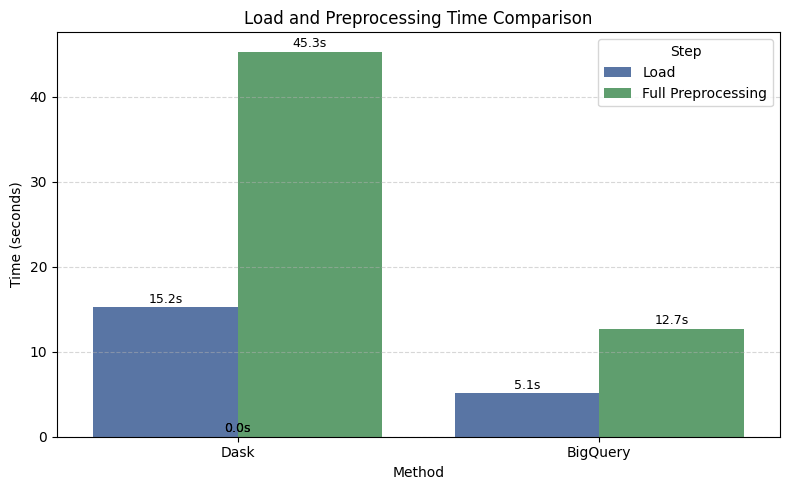

In [ ]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame with all timings
times_df = pd.DataFrame({
    'Method': ['Dask', 'Dask', 'BigQuery', 'BigQuery'],
    'Step': ['Load', 'Full Preprocessing', 'Load', 'Full Preprocessing'],
    'Time (seconds)': [load_time_dask, dask_duration, load_time_bq, bq_duration]
})

plt.figure(figsize=(8, 5))
ax = sns.barplot(data=times_df, x='Method', y='Time (seconds)', hue='Step', palette=['#4C72B0', '#55A868'])

# Add text annotations on bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}s',
                (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom',
                fontsize=9, xytext=(0, 1),
                textcoords='offset points',
                color='black')

plt.title("Load and Preprocessing Time Comparison")
plt.ylabel("Time (seconds)")
plt.xlabel("Method")
plt.legend(title='Step')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

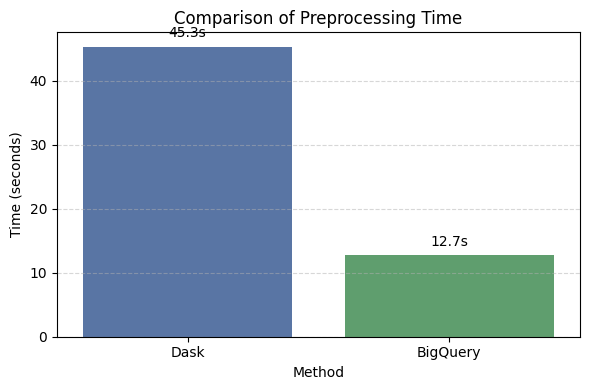

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

dask_duration = 45.3  # example seconds
bq_duration = 12.7    # example seconds

# Prepare the data
times_df = pd.DataFrame({
    'Method': ['Dask', 'BigQuery'],
    'Preprocessing Time (seconds)': [dask_duration, bq_duration]
})

# Plotting
plt.figure(figsize=(6, 4))
sns.barplot(data=times_df, x='Method', y='Preprocessing Time (seconds)', palette=['#4C72B0', '#55A868'])

# Add text annotations on bars
for index, row in times_df.iterrows():
    plt.text(index, row['Preprocessing Time (seconds)'] + 1, f"{row['Preprocessing Time (seconds)']:.1f}s", 
             ha='center', va='bottom')

plt.title("Comparison of Preprocessing Time")
plt.ylabel("Time (seconds)")
plt.xlabel("Method")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

---
---
# ** START FROM HERE **
---
---

🔄 1. Preparação dos dados
    •    Selecionar variáveis úteis: vitais, demográficas, tipo de admissão, valores laboratoriais, etc.
    •    Remover ou imputar valores nulos
    •    Codificar variáveis categóricas (OneHot ou Label Encoding)
    •    Normalizar variáveis numéricas
    •    Definir a variável alvo: LOS (Length of Stay)

⚙️ 2. Dividir em treino/teste
    •    70% treino / 30% teste, ou usar validação cruzada

🧠 3. Treinar modelos

Comparar modelos com:
    •    scikit-learn (ex: Linear Regression, Random Forest, XGBoost)
    •    Dask-ML (ideal se fores escalar)
    •    PySpark MLlib (bom para grandes volumes distribuídos)
    •    BigQuery ML (se quiseres evitar transferência de dados e treinar diretamente na cloud)

📊 4. Avaliar modelos
    •    Métricas de regressão: MAE, RMSE, R²
    •    Comparar tempo de treino, interpretabilidade e escalabilidade

📈 5. Visualizar previsões
    •    Plot de LOS real vs previsto
    •    Curvas de erro residual

# Data Preparation
[[ go back to the top ]](#Table-of-contents)

Este é o Data Frame que vamos trabalhar e usar para a fase de prepração de dados, usando Big Frames. 

In [10]:
# 1. Ler a tabela completa
df_prep = bpd.read_gbq("ml-pipeline-459822.data.raw_features")

/Users/frankiko.mc/.pyenv/versions/big_data-env/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3670: UserWarning: Reading cached table from 2025-06-02 14:31:07.211204+00:00 to avoid
incompatibilies with previous reads of this table. To read the latest
version, set `use_cache=False` or close the current session with
Session.close() or bigframes.pandas.close_session().
  exec(code_obj, self.user_global_ns, self.user_ns)


Passando a parte do trabalho mais ligada a *Machine Learning*, vamos, primeiro de tudo, realizar a preparação dos dados: 

Primeiramente, vamos passar a coluna 'LOS', que é aquilo que queremos prever, para o fim da tabela. 

In [14]:
df_prep.shape

(406235892, 26)

**Valores Nulos**

In [60]:
# Verificar a quantidade de valores nulos por coluna
missing_values = df_prep.isnull().sum()

# Calcular a porcentagem de valores nulos por coluna
missing_percentage = (missing_values / len(df_prep)) * 100

# Combinar as informações em um DataFrame para melhor visualização
missing_data = pd.DataFrame({
    'Valores Nulos': missing_values,
    'Porcentagem (%)': missing_percentage,
    'Tipo de Dado': df_prep.dtypes
})

# Exibir as colunas com valores nulos
missing_data = missing_data[missing_data['Valores Nulos'] > 0]
print(missing_data.sort_values(by='Porcentagem (%)', ascending=False))

                Valores Nulos  Porcentagem (%)                    Tipo de Dado
DEATHTIME           322990326        79.508072  timestamp[us, tz=UTC][pyarrow]
WARNING             244699759        60.235879                           Int64
ERROR               244699759        60.235879                           Int64
CATEGORY            231786720        57.057174                 string[pyarrow]
VALUENUM            223935703        55.124549                         Float64
LANGUAGE            147914535        36.410996                 string[pyarrow]
MARITAL_STATUS       18661087         4.593658                 string[pyarrow]
RELIGION              2693777         0.663107                 string[pyarrow]
VALUE                 2526502         0.621930                 string[pyarrow]
ICUSTAY_ID             261508         0.064373                           Int64
INTIME                 261508         0.064373  timestamp[us, tz=UTC][pyarrow]
LOS                    261508         0.064373      

Aqui está uma estimativa aproximada da percentagem de valores em falta para algumas colunas:

DEATHTIME: ~80%

WARNING: 60%

ERROR: 60%

LANGUAGE: ~36%


Eliminar as colunas, com alta percentagem de valores nulos: (verificar se é efetivamente isso que queremos a fazer)


**AGE**

A idade é uma das variáveis que consideramos importante ao prever o tempo de permanência de um paciente na Unidade de Cuidados Intensivos.
Porém, segundo a documentação existem valores de idade acima dos 300 anos, pelo que estes valores precisam de ser filtrado. 
300 = 90 
301 = 91
(...)

In [67]:
df_prep['AGE'] = df_prep['ADMITTIME'].dt.year - df_prep['DOB'].dt.year
df_prep = df_prep.assign(
    AGE = df_prep['AGE'].where(df_prep['AGE'] < 300, df_prep['AGE'] - 300 + 90)
)
df_prep = df_prep.drop(columns=['ADMITTIME', 'DOB'])


**Valores duplicados**:

In [23]:
duplicados = df_prep[df_prep.duplicated()]
print(f"Número de linhas duplicadas: {len(duplicados)}")

Número de linhas duplicadas: 0


**Verificar colunas categóricas**

In [24]:

string_cols = [col for col, dtype in zip(df_prep.columns, df_prep.dtypes) if dtype == "string"]

for col in string_cols:
    count = df_prep[col].nunique()
    print(f"{col}: {count} valores distintos")

ADMISSION_TYPE: 4 valores distintos
GENDER: 2 valores distintos
ETHNICITY: 41 valores distintos
RELIGION: 20 valores distintos
LANGUAGE: 69 valores distintos
MARITAL_STATUS: 7 valores distintos
INSURANCE: 5 valores distintos
LABEL: 4559 valores distintos
CATEGORY: 56 valores distintos
VALUE: 268260 valores distintos
ICD9_CODE: 5 valores distintos


Vamos agora retirar as colunas com string e não deverão ter relevância para a tarefa de classificação vingente

In [25]:
# 2. Remover colunas indesejadas
colunas_a_remover = ['RELIGION', 'ETHNICITY', 'LANGUAGE', 'MARITAL_STATUS', 'INSURANCE']
df_prep = df_prep.drop(columns=colunas_a_remover)



Passar a coluna gender para: 
    
M -> 1

F -> 0

In [ ]:
print(df_prep.dtypes)

SUBJECT_ID                                       Int64
HADM_ID                                          Int64
ICUSTAY_ID                                       Int64
CHARTTIME                       timestamp[us][pyarrow]
DOB                     timestamp[us, tz=UTC][pyarrow]
ADMITTIME               timestamp[us, tz=UTC][pyarrow]
DISCHTIME               timestamp[us, tz=UTC][pyarrow]
DEATHTIME               timestamp[us, tz=UTC][pyarrow]
HOSPITAL_EXPIRE_FLAG                             Int64
ADMISSION_TYPE                         string[pyarrow]
GENDER                                           Int64
ETHNICITY                              string[pyarrow]
RELIGION                               string[pyarrow]
LANGUAGE                               string[pyarrow]
MARITAL_STATUS                         string[pyarrow]
INSURANCE                              string[pyarrow]
ITEMID                                           Int64
LABEL                                  string[pyarrow]
VALUE     

In [26]:

df_prep["GENDER"] = df_prep["GENDER"].map({"F": 0, "M": 1})



Como a tabela 'LABEL' tem vários valores distintos, eles estão organizados em categorias na coluna 'CATEGORY', então basta-nos ter esta coluna como relevante. 

In [ ]:
df_prep['ITEMID'].shape


(406235892,)

In [15]:
df_prep['ITEMID']


0       8554
1        161
2     224689
3     223943
4        581
5     224979
6     220060
7     224733
8       1337
9     224085
10    223794
11        52
12       325
13    227954
14    225730
15    227956
16      1484
17        88
18    224085
19      8456
20       618
21    227345
22       455
23    224080
24       644
Name: ITEMID, dtype: Int64

In [ ]:
df_prep.groupby('ITEMID')['VALUEUOM'].nunique().reset_index().query('VALUEUOM > 1')

,ITEMID,VALUEUOM
91,113,2
182,211,2
472,578,2
1924,3451,2
2075,3723,2


In [19]:
itemid_to_check = 52  # replace with your desired ITEMID

df_prep[df_prep['ITEMID'] == itemid_to_check][['ITEMID', 'LABEL', 'VALUEUOM']]

,ITEMID,LABEL,VALUEUOM
11,52,Arterial BP Mean,mmHg
338,52,Arterial BP Mean,mmHg
447,52,Arterial BP Mean,mmHg
541,52,Arterial BP Mean,mmHg
577,52,Arterial BP Mean,mmHg
617,52,Arterial BP Mean,mmHg
749,52,Arterial BP Mean,mmHg
882,52,Arterial BP Mean,mmHg
900,52,Arterial BP Mean,mmHg
962,52,Arterial BP Mean,mmHg


O problema que esta coluna é um número muito maior de valores nulos. 

-------

## Dividir os conjunto de Dados Em Treino e Teste

**Big Frames**

In [ ]:
# Ordenar o DataFrame pelo tempo
df_sorted = df_prep.sort_values("INTIME")

# Contar número total de linhas
row_count = df_sorted.shape[0].compute()
print("Número de linhas do data set após a fase de preparação de dados:", row_count)

# Calcular índice de divisão (80%)
split_index = int(row_count * 0.8)

# Fazer a divisão temporal
df_train = df_sorted.iloc[:split_index]
df_test = df_sorted.iloc[split_index:]

ValueError: Column name INTIME doesn't exist

--------

In [ ]:
def split_data(df, test_size=0.2, val_size=0.1):
    """
    Splits the data into training, validation, and testing sets.

    Args:
        df (DataFrame): DataFrame containing the dataset.
        test_size (float): Proportion of the dataset to include in the test split.
        val_size (float): Proportion of the dataset to include in the validation split.

    Returns:
        tuple: Three DataFrames containing the training, validation, and testing sets.
    """
    unique_subject_ids = df['SUBJECT_ID'].unique()

    train_ids, test_ids = train_test_split(unique_subject_ids, test_size=test_size)
    train_ids, val_ids = train_test_split(train_ids, test_size=val_size / (1 - test_size))

    train_df = df[df['SUBJECT_ID'].isin(train_ids)]
    val_df = df[df['SUBJECT_ID'].isin(val_ids)]
    test_df = df[df['SUBJECT_ID'].isin(test_ids)]

    return train_df, val_df, test_df

def preprocess_data(df):
    """
    Preprocesses the data by converting it to a pandas DataFrame, performing feature engineering,
    and converting it back to BigFrame.

    Args:
        df (DataFrame): DataFrame containing the dataset.

    Returns:
        DataFrame: Preprocessed DataFrame.
    """
    df['DISCHTIME'] = pd.to_datetime(df['DISCHTIME']).astype(int)

    df['DEATHTIME'] = df['DEATHTIME'].replace('unknown', pd.NaT)

    df['DEATHTIME'] = pd.to_datetime(df['DEATHTIME']).astype(int)

    df = pd.get_dummies(df, columns=['ADMISSION_TYPE', 'GENDER', 'ETHNICITY', 'RELIGION', 'LANGUAGE', 'MARITAL_STATUS', 'INSURANCE', 'LABEL', 'ERROR', 'DBSOURCE', 'SHORT_TITLE', 'VALUE'])

    df['SUBJECT_ID'] = df['SUBJECT_ID'].astype(int)
    df['HADM_ID'] = df['HADM_ID'].astype(int)
    df['ICUSTAY_ID'] = df['ICUSTAY_ID'].astype(int)
    df['ITEMID'] = df['ITEMID'].astype(int)
    df['ICD9_CODE'] = df['ICD9_CODE'].astype(int)
    df['SEQ_NUM'] = df['SEQ_NUM'].astype(int)
    df['AGE'] = df['AGE'].astype(int)

    return df

# Preprocess the data
preprocessed_df = preprocess_data(dask_df.compute())

# Split the data into training, validation, and testing sets
train_df, val_df, test_df = split_data(preprocessed_df)

# Extract features and target variable for training
X_train = train_df.iloc[:, :-1]
y_train = train_df['LOS']

# Extract features and target variable for validation
X_val = val_df.iloc[:, :-1]
y_val = val_df['LOS']

# Extract features and target variable for testing
X_test = test_df.iloc[:, :-1]
y_test = test_df['LOS']

# Fit a linear regression model on the training data
model = LinearRegression()
model.fit(X_train, y_train)

# Cross-validation to evaluate the model on the validation set
mse_scores = cross_val_score(model, X_val, y_val, scoring='neg_mean_squared_error', cv=5)
mse_mean = -mse_scores.mean()
print('Mean Squared Error on Validation Set (Cross-Validation):', mse_mean)

# Evaluate the model on the test set
y_pred_test = model.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)
print('Mean Squared Error on Test Set:', mse_test)

NameError: name 'dask_df' is not defined

# Test

In [ ]:
agg = raw_features.groupby(['ICUSTAY_ID', 'LABEL'])['VALUENUM'].agg(['mean', 'min', 'max', 'std']).reset_index()
pivot = agg.pivot(index='ICUSTAY_ID', columns='LABEL', values='mean')  # example for 'mean'

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X = df.drop(columns=['LOS'])
y = df['LOS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_jobs=-1)  # parallelism
model.fit(X_train, y_train)
preds = model.predict(X_test)

print("RMSE:", mean_squared_error(y_test, preds, squared=False))


BadRequest: 400 GET https://bigquery.googleapis.com/bigquery/v2/projects/ml-pipeline-459822/queries/job_JsW0uLDvQCmkZsjGezQ-Mw971hG8?maxResults=0&location=europe-west3&prettyPrint=false: Bad double value: ELECTIVE

Location: europe-west3
Job ID: job_JsW0uLDvQCmkZsjGezQ-Mw971hG8
